In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout

In [2]:
test = {'dataset': ['cardio', 'gas-drift', 'satellite'],
        'ensemble models': [0.962390, 0.993270, 0.863251],
        'autoencoder models': [0.953642, 0.993657, 0.862183]}
df = pd.DataFrame.from_dict(test)
df

,dataset,ensemble models,autoencoder models
0,cardio,0.962390,0.953642
1,gas-drift,0.993270,0.993657
2,satellite,0.863251,0.862183


# I. Writing all functions that we need to use later

## 1. Feature scaling


In [3]:
def scaler(X_tra, X_te, scaler="minmax"):
  """
  Feature scaling using MinMaxScaler oder StandardScaler

  Arguments:
  X_tra -- traing dataset before scaling
  X_te -- test dataset before scaling
  scaler -- scaler methods: minmax = MinMaxScaler; standard = StandardScaler

  Returns:
  X_train -- scaled training set
  X_test -- scaled test set
  """
  from sklearn.preprocessing import MinMaxScaler, StandardScaler

  if scaler == "standard":
    sc = StandardScaler()
  else:
    sc = MinMaxScaler(feature_range=(0, 1))
  
  X_train = sc.fit_transform(X_tra.copy())
  X_test = sc.transform(X_te.copy())
  return X_train, X_test

## 2. Create Autoencoder Model

In [4]:
# Create a model by subclassing Model class in tensorflow
class Autoencoder(Model):
  """
  An autoencoder with Encoder and decoder blocks and adjustable size of laten space
  
  Arguments:
    input_dim -- number of NN units at layer 0 (input)
    latent -- size of laten space layer
         
  Returns: 
    autoencoder -- autoencoder Model
  """

  def __init__(self, input_dim, latent):
    super().__init__()
    # encoder block
    self.encoder = Sequential([
        Dense(latent * 8, activation='relu'),
        Dropout(0.1),
        Dense(latent * 4, activation='relu'),
        Dropout(0.1),
        Dense(latent * 2, activation='relu'),
        Dropout(0.1),
        Dense(latent, activation='relu')
    ])
    # Decoder block
    self.decoder = Sequential([
        Dense(latent * 2, activation='relu'),
        Dropout(0.1),
        Dense(latent * 4, activation='relu'),
        Dropout(0.1),
        Dense(latent * 8, activation='relu'),
        Dropout(0.1),
        Dense(input_dim, activation='sigmoid')
    ])

  def call(self, inputs):
    encode = self.encoder(inputs)
    decode = self.decoder(encode)
    return decode

### 2.a. Training model using the loss function `Mean Square Error`:

Pros of mse:
  * MSE penalises the model for having huge errors by squaring them.
  * It is particularly helpful in weeding out outliers with large errors from the model by putting more weight on them.

**source:** https://medium.com/analytics-vidhya/loss-functions-to-evaluate-regression-models-8dac47e327e2

https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

In [5]:
def training_model(model_architecture, X_train, X_test, latent = 4, verbose = 0, loss = "mse", epochs=50, batch_size=128):
  """
  training a model

  Arguments:
    model_architecture -- architecture of model, which is used to train model
    X_train  -- input data
    X-test -- test data
    latent -- the size of latent space applied for model_architecture
    loss -- the loss metrics is used for training model
    epochs -- number of training loops
    batch_size
    verbose -- showing progress of trainin model

  Returns:
    autoencoder -- the trained model
    history -- the history of trained model
  """
  # Set random seed
  #tf.keras.utils.set_random_seed(42)

  # Create autoencoder model
  autoencoder = model_architecture(input_dim=X_train.shape[1], latent = latent)

  # callback will stop the training when there is no improvement in the validation loss for 50 consecutive epochs
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50)   #  Training will stop when the val_loss starts to increase 

  # Loss and optimizer definition
  autoencoder.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss=loss,  #  Computes the mean of squares of errors between y_true & y_pred.
                      metrics=[loss]) 

  # Fit the autoencoder
  history= autoencoder.fit(x=X_train, 
                          y=X_train,
                          epochs=epochs,
                          batch_size=batch_size,
                          verbose = verbose,
                          callbacks = [callback],
                          validation_split=0.2,   # Fraction of the training data to be used as validation data
                          shuffle=True)
  return autoencoder, history

### 2.b. Function to measure the performance of model in detecting outlier

https://stackoverflow.com/questions/65398299/proper-inputs-for-scikit-learn-roc-auc-score-and-roc-plot

In [ ]:
def performance(model, X_test, y_test, plot = True):
  """
  Measure performance of trained model mit AUC score using built-in function in sklearn

  Arguments:
    model -- trained model
    X_test -- data which are used to test the trained model
    y_test -- this contains labels of X_test. 
    plot -- True: plot the ROC curve. False: does not plot the ROC curve
         
  Returns: 
    AUC -- the AUC score
    ROC curve
  """

  # getting predictions (recontructions) of the test data
  preds = model.predict(X_test)
  # calculate the difference between predictions and test data using mean square error
  pred_errors = tf.keras.losses.mse(preds, X_test)
  # Check the prediction performance
  auc_score = roc_auc_score(y_test, pred_errors)
  if not plot:
    print(f"AUC score: {auc_score}")
  else:
    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = roc_curve(y_test, pred_errors)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % auc_score)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### 2.c. Check the effect of laten space on the model.


In [ ]:
def effect_latent(model_architecture, X_train, X_test, y_test, latent_list, loss = "mse", epochs=50, batch_size=128, print=False):
  """
  This function will check the effect of the size of laten space on the model

  Arguments:
    model_architecture -- architecture of model, which is used to train model
    latent_list -- list contains the sizes of laten space that we want to use for our model

  Returns:

  """
  # list contains auc_score of trained models
  auc_list = []
  # training model with different sizes of latent space
  for i in latent_list:
    model, hist = training_model(model_architecture, X_train, X_test, latent = i, loss = loss, epochs=epochs, batch_size=batch_size)

    #getting predictions (recontructions) of the test data
    preds = model.predict(X_test)
    # calculate the difference between predictions and test data using mean square error
    pred_errors = tf.keras.losses.mse(preds, X_test)
    # Check the prediction performance
    auc_score = roc_auc_score(y_test, pred_errors)
    auc_list.append(auc_score)
    if print:
     print(f"Latent = {i}: AUC score = {auc_score}")

  # plot the effect of latent space on trained models
  plt.plot(latent_list, auc_list)
  plt.title('The effect of latent space on models')
  plt.xlabel("Latent size")
  plt.ylabel("AUC score")
  plt.show()

## 3.  Test new architecture of model

Adding one more hidden layer in architecture model of Autoencoder. But the result of trained model based on new AutoencoderV2 is worse than Autoencoder. So we use the architecture of Autoencoder


## 4. Ensemble Model

Build not only a single autoencoder, but an ensemble of them: 

  * first build multiple autoencoder (in a loop)
  * then average their anomaly scores (first calculate the difference between inputs and theirs predictions, then average it)
  * Calculate the final auc score

Then create a plot, showing how this final auc score depends on the
number of models used.


*Example for using tf.math.reduce_mean()*: https://i0.wp.com/www.datasciencelearner.com/wp-content/uploads/2021/08/Mean-of-tensor-of-Multi-dimensional-row-wise.jpg?ssl=1

# II. Testing with different datasets

## 0. Getting data

three datasets: `cardio.npz`, `gas-drift.npz`, `satellite.npz`

A dataset includes:

* `x` : training data (all are normal samples)
* `tx` : test data samples (some normal, some abnormal)
* `ty` : tells you which are normal and which are not.
  * our autoencoder would reconstruct every sample with
ty=0 very well, and make mistakes when ty=1

In [ ]:
# This code allows us to upload data from local drive
from google.colab import files
uploaded = files.upload()

Saving satellite.npz to satellite.npz


In [ ]:
cardio = np.load('cardio.npz')
gas_drift = np.load('gas-drift.npz')
satellite = np.load('satellite.npz')

In [ ]:
def extract_data(dataset):
  """
  This function extract X_train, X_test, y_test from a dataset and apply MinMaxScaler on X_train, X_test

  Arguments:
    dataset -- a dataset contains features x, tx, ty

  Returns:
  X_train: scaled x
  X_test: scaled tx
  y_test: ty
  """
  X_tra = dataset['x']
  X_te = dataset['tx']
  y_test= dataset['ty']
  # Feature scaling
  X_train, X_test = scaler(X_tra, X_te, scaler="minmax")
  return X_train, X_test, y_test

In [ ]:
def info(data:list):
  """
  This function prints out an overview of all training datasets in data list in a dataframe
  
  Arguments:
    data -- a list of datasets
  
  Returns:
    a dataframe with name of dataset, shape, ndim, min, max
  """

  df = {'dataset':['cardio', 'gas-drift', 'satellite'],
        'shape': [],
        'ndim': [],
        'min': [],
        'max':[]}
  for da in data:
    df['shape'].append(da['x'].shape)
    df['ndim'].append(da['x'].ndim)
    df['min'].append(da['x'].min())
    df['max'].append(da['x'].max())
  info = pd.DataFrame.from_dict(df)
  return info

In [ ]:
info = info([cardio, gas_drift, satellite])
info

,dataset,shape,ndim,min,max
0,cardio,"(1479, 21)",2,-3.004892,14.025335
1,gas-drift,"(1796, 128)",2,-4839.446289,231364.171875
2,satellite,"(3080, 36)",2,31.000000,139.000000


## 1. Inspect the effect of autoencoder on the models

* plot the auc scores of models trained with Autoencoder architecture

In [ ]:
def inspect_autoencoder(model_architecture, latent_list: list, data: list, legend: list, epochs):
  """
  This function calculate auc scores of datasets using autoencoder model and  show us the ROC curve and AUC score 

  Arguments:
    model_architecture -- the model architecture that we want to use to create model
    data -- a list of datasets
    legend -- name of datasets used to display on plot
  Returns:
    aut_dict -- this dictionary contains auc scores of datasets
  """
  # Set random seed
  tf.keras.utils.set_random_seed(42)
  
  aut_dict = {'dataset': legend, 'auc': []}

  for n in range(len(data)):
    df = data[n] # extract dataset n in data
    # extract X_train, X_test, y_test in df and scaled X_train, X_test
    X_train, X_test, y_test = extract_data(df)

    # create and train autoencoder for each dataset
    autoencoder, history = training_model(model_architecture, X_train, X_test, latent = latent_list[n], epochs=epochs)
    # getting predictions (recontructions) of the test data
    preds = autoencoder.predict(X_test)
    # calculate the difference between preds and test data using mean square error
    pred_errors = tf.keras.losses.mse(preds, X_test)
    # Check the prediction performance
    auc_score = roc_auc_score(y_test, pred_errors)
    aut_dict['auc'].append(auc_score)

    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = roc_curve(y_test, pred_errors)
    plt.plot(fpr, tpr, label = f"{legend[n]}: {auc_score}")
    
  plt.legend(loc='lower right')
  plt.title('Receiver Operating Characteristic using Autoencoder ')
  plt.plot([0, 1], [0, 1],'r--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  return aut_dict

83/83 [==============================] - 0s 2ms/step


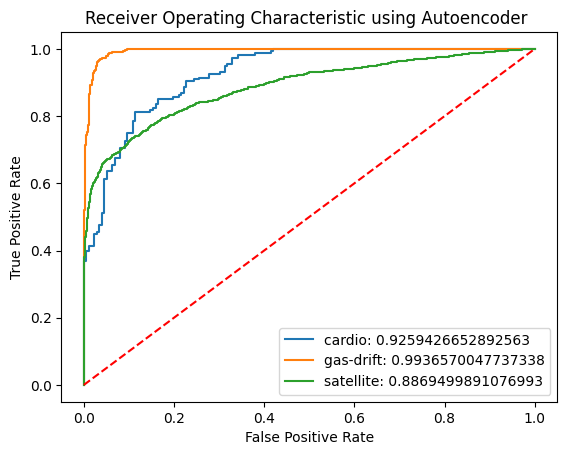

In [ ]:
aut_dict = inspect_autoencoder(Autoencoder, latent_list = [4, 112, 64], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'], epochs = 1000)

In [ ]:
def validation_autoencoder(model_architecture, latent_list: list, data: list, legend: list, epochs):
  """
  This function calculate auc scores of datasets using autoencoder model and  show us the ROC curve and AUC score 

  Arguments:
    model_architecture -- the model architecture that we want to use to create model
    data -- a list of datasets
    legend -- name of datasets used to display on plot
  Returns:
    val_dict -- this dictionary contains auc scores of datasets
    loss -- losses of each dataset during training. 
    val_loss -- validation loss of each dataset during training
  """
  # Set random seed
  tf.keras.utils.set_random_seed(42)
  
  val_dict = {'dataset': legend, 'auc': [], 'loss': [], 'val_loss': []}

  for n in range(len(data)):
    df = data[n] # extract dataset n in data
    # extract X_train, X_test, y_test in df and scaled X_train, X_test
    X_train, X_test, y_test = extract_data(df)

    # create and train autoencoder for each dataset
    autoencoder, history = training_model(model_architecture, X_train, X_test, latent = latent_list[n], epochs=epochs)
    # getting predictions (recontructions) of the test data
    preds = autoencoder.predict(X_test)
    # calculate the difference between preds and test data using mean square error
    pred_errors = tf.keras.losses.mse(preds, X_test)
    # Check the prediction performance
    auc_score = roc_auc_score(y_test, pred_errors)
    val_dict['auc'].append(auc_score)
    val_dict['loss'].append(history.history['loss'])
    val_dict['val_loss'].append(history.history['val_loss'])

    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = roc_curve(y_test, pred_errors)
    plt.plot(fpr, tpr, label = f"{legend[n]}: {auc_score}")
    
  plt.legend(loc='lower right')
  plt.title('Receiver Operating Characteristic using Autoencoder ')
  plt.plot([0, 1], [0, 1],'r--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  return val_dict

83/83 [==============================] - 0s 4ms/step


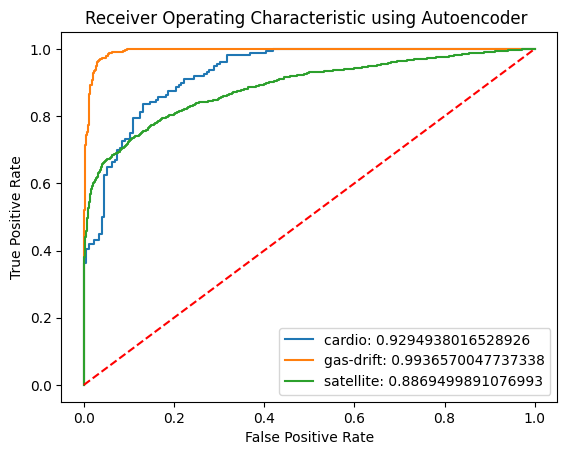

In [ ]:
val_dict = validation_autoencoder(Autoencoder, latent_list = [4, 112, 64], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'], epochs = 2000)

In [ ]:
def plot_loss(epochs, loss:list, val_loss:list, legend: list):
  """
  This function plot the dependency of epochs, loss and val_loss of each trained model 

  Arguments:
    epochs -- number of epochs used to train model
    loss -- loss list of a trained model
    val_loss -- validation loss list of a trained model
    legend -- names of datasets used to train models
  
  Returns:
    plot
  """
  fig = plt.figure(figsize=(17, 6))
  plt.subplot(1, 3, 1)
  plt.plot(range(1, len(loss[0]) + 1), loss[0], 'g', label='Training loss')
  plt.plot(range(1, len(loss[0]) + 1), val_loss[0], 'r', label='Validation loss')
  plt.title(legend[0])
  plt.xlabel('Epochs')
  plt.xscale('log')   # check this 
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 3, 2)
  plt.plot(range(1, len(loss[1]) + 1), loss[1], 'g', label='Training loss')
  plt.plot(range(1, len(loss[1]) + 1), val_loss[1], 'r', label='Validation loss')
  plt.title(legend[1])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 3, 3)
  plt.plot(range(1, len(loss[2]) + 1), loss[2], 'g', label='Training loss')
  plt.plot(range(1, len(loss[2]) + 1), val_loss[2], 'r', label='Validation loss')
  plt.title(legend[2])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  fig.tight_layout(pad=5.0)
  plt.show()

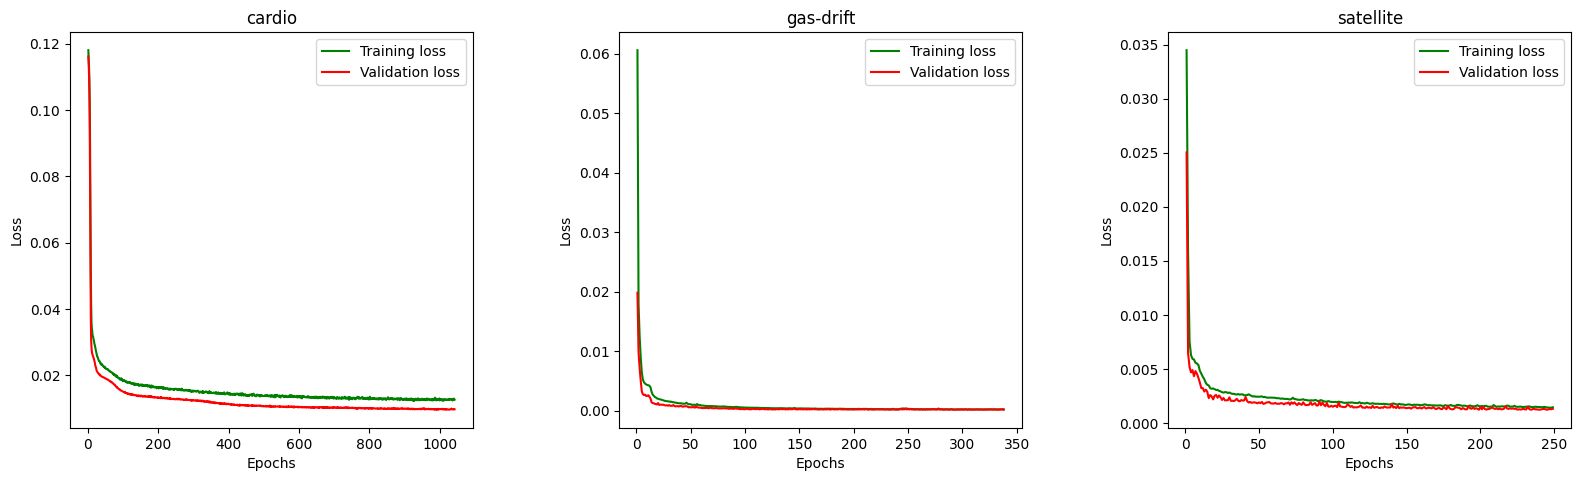

In [ ]:
# patience is set up to 50 in training model
plot_loss(2000, loss=val_dict['loss'], val_loss=val_dict['val_loss'], legend=['cardio', 'gas-drift', 'satellite'])

83/83 [==============================] - 0s 3ms/step


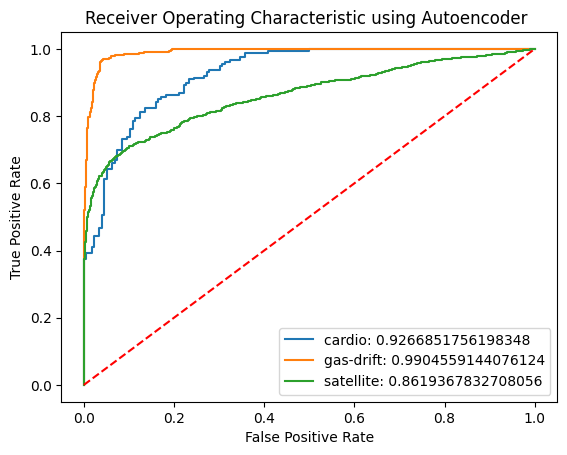

In [ ]:
# patience is set up to 70 in training model
val_dict_2 = validation_autoencoder(Autoencoder, latent_list = [4, 112, 64], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'], epochs = 2000)

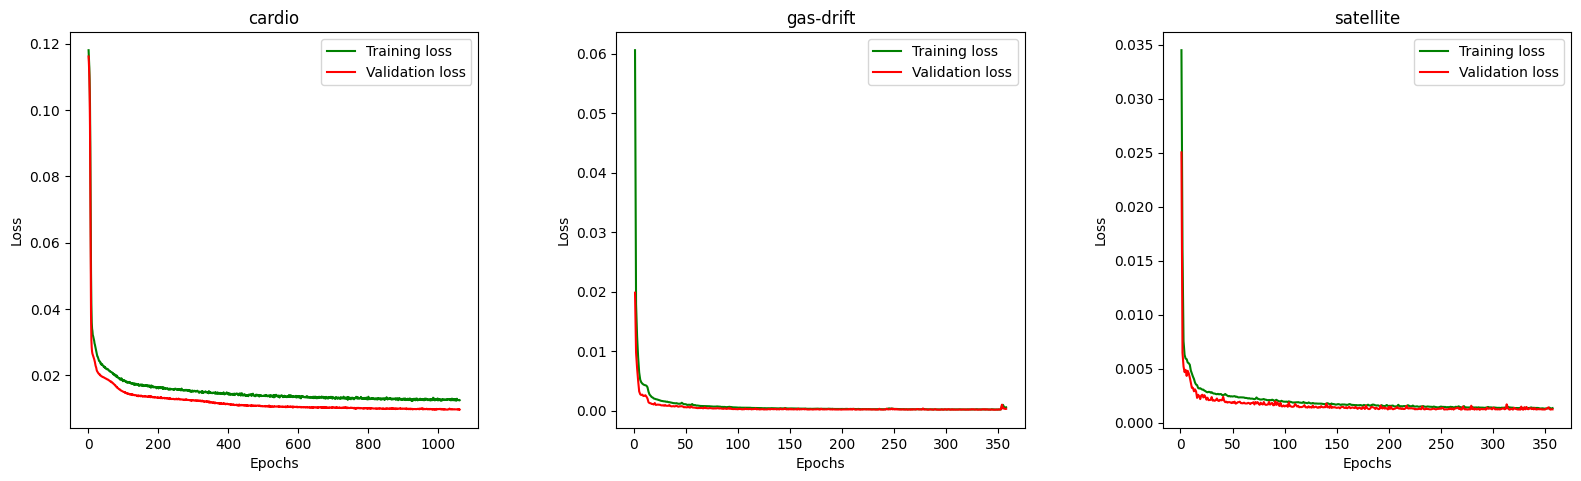

In [ ]:
plot_loss(2000, loss=val_dict_2['loss'], val_loss=val_dict_2['val_loss'], legend=['cardio', 'gas-drift', 'satellite'])

## 2. Correlation between Autoencoder models and the number of epochs

We try to figure out the relationship between AUC score of Autoencoder models with epochs

In [ ]:
def inspect_epochs(model_architecture, epoch_list: list, latent_list: list, data:list, legend:list):
  """
  This function show us the correlation between epochs and AUC score
  
  Arguments:
    model_architecture -- the model architecture that we want to use to create model
    data -- a list of datasets
    latent_list  - this contains the latent space of each dataset respectively
    legend -- name of datasets used to display on plot
    epoch_list -- a list of different epochs
  Returns:
    plot
    epoch_dict -- this dictionary contains AUC score of each dataset according to each epoch value
  """
  # Set random seed
  tf.keras.utils.set_random_seed(42)
  epoch_dict = {'dataset': legend, 'auc': [], 'epochs': epoch_list}

  for n in range(len(data)):
    df = data[n]
    # extract X_train, X_test, y_test in df and scaled X_train, X_test
    X_train, X_test, y_test = extract_data(df)
    # list contains auc_score of trained models
    auc_list = []
    # training model with different sizes of latent space
    for epoch in epoch_list:
      model, hist = training_model(model_architecture, X_train, X_test, latent = latent_list[n], loss = 'mse', epochs=epoch, batch_size=128)

      #getting predictions (recontructions) of the test data
      preds = model.predict(X_test)
      # calculate the difference between predictions and test data using mean square error
      pred_errors = tf.keras.losses.mse(preds, X_test)
      # Check the prediction performance
      auc_score = roc_auc_score(y_test, pred_errors)
      auc_list.append(auc_score)

    epoch_dict['auc'].append(auc_list)
    # plot the effect of latent space on trained models
    plt.plot(epoch_list, auc_list)
    
  plt.legend(legend, loc='lower right')
  plt.title('Correlation between epochs and AUC scores of trained models')
  plt.xlabel("epoch size")
  plt.ylabel("AUC score")
  plt.show()
  return epoch_dict


83/83 [==============================] - 0s 3ms/step


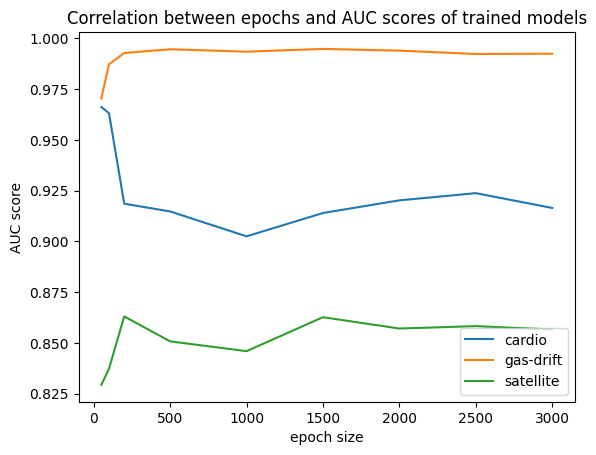

In [ ]:
epoch_dict_2 = inspect_epochs(Autoencoder, epoch_list=[50, 100, 200, 500, 1000, 1500, 2000, 2500, 3000], latent_list=[4, 112, 64], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'])

In [ ]:
# create a dictionary contains all AUC scores of all datasets for each epoch value was used to train
epoch_auc_dict_2 = {'epoch size': [50, 100, 200, 500, 1000, 1500, 2000, 2500, 3000],
               'cardio': epoch_dict_2['auc'][0],
               'gas-drift': epoch_dict_2['auc'][1],
               'satellite': epoch_dict_2['auc'][2]}

epoch_auc_2 = pd.DataFrame.from_dict(epoch_auc_dict_2)
epoch_auc_2

,epoch size,cardio,gas-drift,satellite
0,50,0.966200,0.970453,0.829301
1,100,0.963230,0.987229,0.837254
2,200,0.918582,0.992818,0.863049
3,500,0.914773,0.994677,0.850763
4,1000,0.902505,0.993471,0.845935
5,1500,0.913998,0.994839,0.862667
6,2000,0.920229,0.993992,0.857084
7,2500,0.923780,0.992335,0.858271
8,3000,0.916484,0.992475,0.856608


* **?? Why does cardio dataset only need 50 epochs to get the best AUC score**

## 3. Correlation between batch_size and AUC scores of models

* we train autoencoders with epochs = 1500 and different batch_size

In [ ]:
def inspect_batchsize(model_architecture, batch_size: list, latent_list: list, data:list, legend:list, epoch):
  """
  This function show us the correlation between epochs and AUC score
  
  Arguments:
    model_architecture -- the model architecture that we want to use to create model
    batch_size -- a list contains different batch sizes
    data -- a list of datasets
    latent_list  - this contains the latent space of each dataset respectively
    legend -- name of datasets used to display on plot
  Returns:
    plot
    batch_dict -- this dictionary contains AUC score of each dataset according to each batch size
  """
  # Set random seed
  tf.keras.utils.set_random_seed(42)
  batch_dict = {'dataset': legend, 'auc': [], 'batch_size': batch_size}

  for n in range(len(data)):
    df = data[n]
    # extract X_train, X_test, y_test in df and scaled X_train, X_test
    X_train, X_test, y_test = extract_data(df)
    # list contains auc_score of trained models
    auc_list = []
    # training model with different batch sizes
    for batch in batch_size:
      model, hist = training_model(model_architecture, X_train, X_test, latent = latent_list[n], loss = 'mse', epochs=epoch, batch_size=batch)

      #getting predictions (recontructions) of the test data
      preds = model.predict(X_test)
      # calculate the difference between predictions and test data using mean square error
      pred_errors = tf.keras.losses.mse(preds, X_test)
      # Check the prediction performance
      auc_score = roc_auc_score(y_test, pred_errors)
      auc_list.append(auc_score)

    batch_dict['auc'].append(auc_list)
    # plot the effect of latent space on trained models
    plt.plot(batch_size, auc_list)
    
  plt.legend(legend, loc='best')
  plt.title('Correlation between batch size and AUC scores of trained models')
  plt.xlabel("batch size")
  plt.ylabel("AUC score")
  plt.show()
  return batch_dict


83/83 [==============================] - 0s 3ms/step


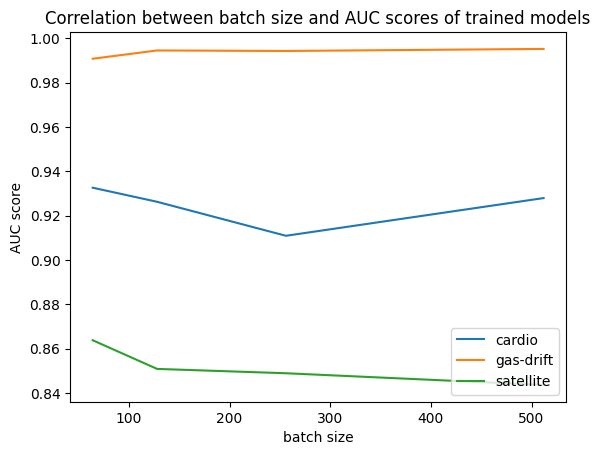

In [ ]:
batch_size = inspect_batchsize(Autoencoder, batch_size=[64, 128, 256, 512], latent_list=[4, 112, 64], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'], epoch=1500)

In [ ]:
# create a dictionary contains all AUC scores of all datasets for each batch size value was used to train
batch_auc= {'batch size': [64, 128, 256, 512],
               'cardio': batch_size['auc'][0],
               'gas-drift': batch_size['auc'][1],
               'satellite': batch_size['auc'][2]}

batch_df = pd.DataFrame.from_dict(batch_auc)
batch_df

,batch size,cardio,gas-drift,satellite
0,64,0.932561,0.990750,0.863729
1,128,0.926201,0.994486,0.850800
2,256,0.910866,0.994252,0.848842
3,512,0.927880,0.995177,0.843575


83/83 [==============================] - 0s 2ms/step


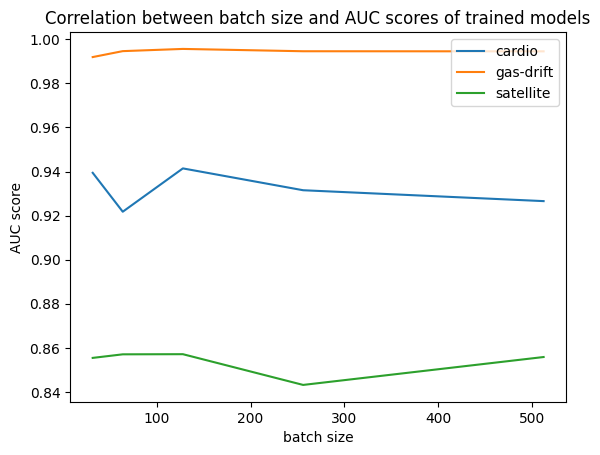

In [ ]:
batch_size_2 = inspect_batchsize(Autoencoder, batch_size=[32, 64, 128, 256, 512], latent_list=[4, 112, 64], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'], epoch=1500)

In [ ]:
# create a dictionary contains all AUC scores of all datasets for each batch size value was used to train
batch = {'batch size': [32, 64, 128, 256, 512],
               'cardio': batch_size_2['auc'][0],
               'gas-drift': batch_size_2['auc'][1],
               'satellite': batch_size_2['auc'][2]}

batch_df_2 = pd.DataFrame.from_dict(batch)
batch_df_2

,batch size,cardio,gas-drift,satellite
0,32,0.939437,0.991961,0.855438
1,64,0.921778,0.994656,0.857057
2,128,0.941439,0.995661,0.857121
3,256,0.931528,0.994606,0.843172
4,512,0.926588,0.994562,0.855834


## 2. Inspect the effect of latent space on the models

* We inspect the correlation between size of latent space and AUC score of models of different datasets
* We set epochs=1500 and batch_size=128

In [ ]:
def inspect_latent(model_architecture, latent_list: list, data:list, legend:list, epochs, batch):
  """
  This function show us the correlation between latent space and AUC score
  
  Arguments:
    model_architecture -- the model architecture that we want to use to create model
    data -- a list of datasets
    legend -- name of datasets used to display on plot
    epochs
    batch
  Returns:
    plot
    latent_dict -- this dictionary contains AUC scores of each datasets at each latent space
  """
  # Set random seed
  tf.keras.utils.set_random_seed(42)
  latent_dict = {'dataset': legend, 'auc': [], 'latent space': latent_list}

  for n in range(len(data)):
    df = data[n]
    # extract X_train, X_test, y_test in df and scaled X_train, X_test
    X_train, X_test, y_test = extract_data(df)
    # list contains auc_score of trained models
    auc_list = []
    # training model with different sizes of latent space
    for i in latent_list:
      model, hist = training_model(model_architecture, X_train, X_test, latent = i, loss = 'mse', epochs=epochs, batch_size=batch)

      #getting predictions (recontructions) of the test data
      preds = model.predict(X_test)
      # calculate the difference between predictions and test data using mean square error
      pred_errors = tf.keras.losses.mse(preds, X_test)
      # Check the prediction performance
      auc_score = roc_auc_score(y_test, pred_errors)
      auc_list.append(auc_score)

    latent_dict['auc'].append(auc_list)
    # plot the effect of latent space on trained models
    plt.plot(latent_list, auc_list)
    
  plt.legend(legend, loc='best')
  plt.title('Correlation between latent space and AUC scores of trained models')
  plt.xlabel("Latent size")
  plt.ylabel("AUC score")
  plt.show()
  return latent_dict


83/83 [==============================] - 1s 6ms/step


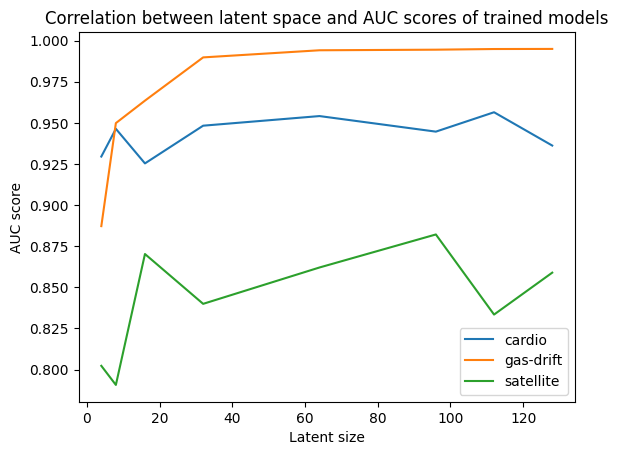

In [ ]:
latent_dict = inspect_latent(Autoencoder, latent_list = [4, 8, 16, 32, 64, 96, 112, 128] , data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'], epochs=1500, batch=128)

* From this plot, we see that training a model with the size of latent space greater than the amount of features of training dataset can also get the better result.

In [ ]:
# create a dictionary contains all AUC scores of all datasets for each latent size value was used to train
latent_auc = {'latent space': [4, 8, 16, 32, 64, 96, 112, 128],
               'cardio': latent_dict['auc'][0],
               'gas-drift': latent_dict['auc'][1],
               'satellite': latent_dict['auc'][2]}

latent_df = pd.DataFrame.from_dict(latent_auc)
latent_df

,latent space,cardio,gas-drift,satellite
0,4,0.929494,0.887208,0.802311
1,8,0.946346,0.949812,0.790704
2,16,0.925329,0.963472,0.870251
3,32,0.948250,0.989749,0.839979
4,64,0.954093,0.994081,0.862075
5,96,0.944635,0.994438,0.882142
6,112,0.956418,0.994839,0.833466
7,128,0.936176,0.994902,0.858932


11/11 [==============================] - 0s 5ms/step


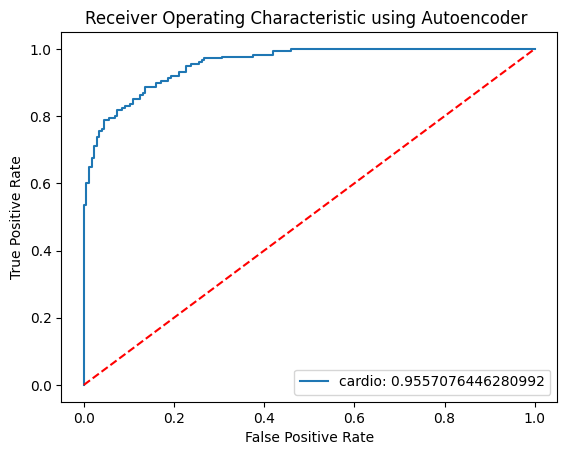

In [ ]:
test_cardio = inspect_autoencoder(Autoencoder, latent_list = [112], data = [cardio], legend = ['cardio'], epochs = 1500)

11/11 [==============================] - 0s 7ms/step


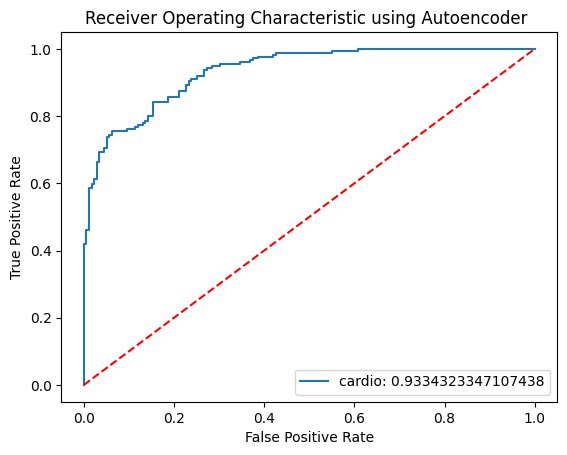

In [ ]:
test_cardio_2 = inspect_autoencoder(Autoencoder, latent_list = [112], data = [cardio], legend = ['cardio'], epochs = 50)

11/11 [==============================] - 0s 2ms/step


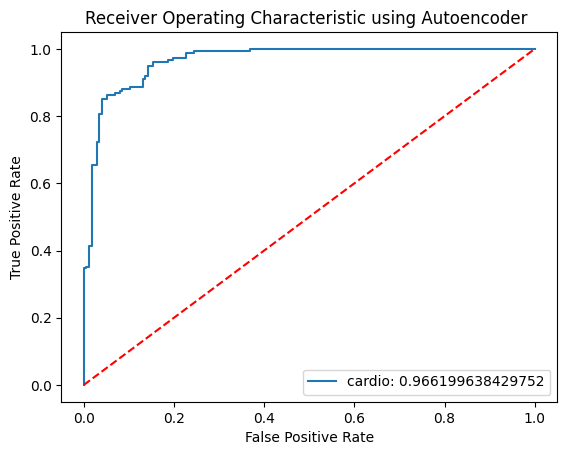

In [ ]:
test_cardio_3 = inspect_autoencoder(Autoencoder, latent_list = [4], data = [cardio], legend = ['cardio'], epochs = 50)

83/83 [==============================] - 1s 6ms/step


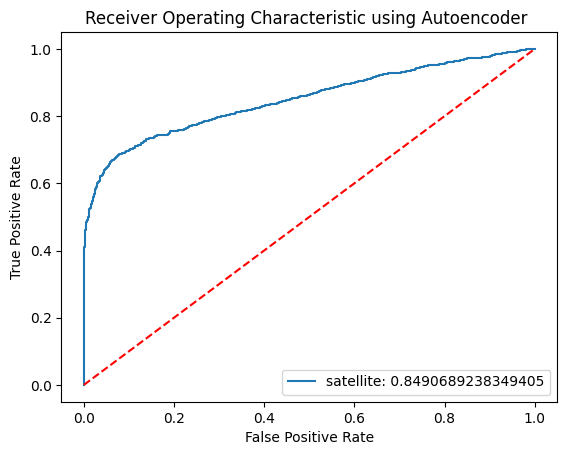

In [ ]:
test_satellite = inspect_autoencoder(Autoencoder, latent_list = [112], data = [satellite], legend = ['satellite'], epochs = 1500)

83/83 [==============================] - 0s 1ms/step


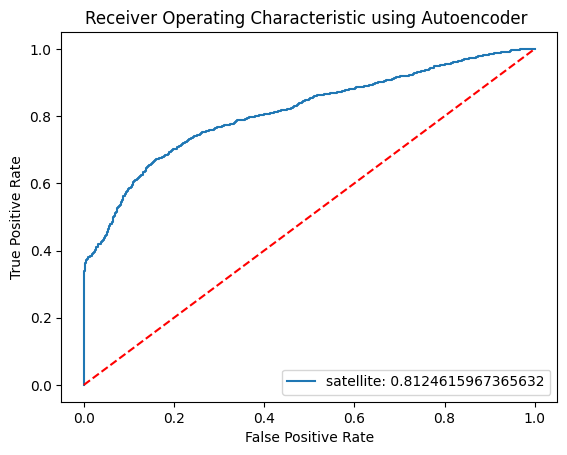

In [ ]:
test_satellite_2 = inspect_autoencoder(Autoencoder, latent_list = [8], data = [satellite], legend = ['satellite'], epochs = 100)

83/83 [==============================] - 0s 2ms/step


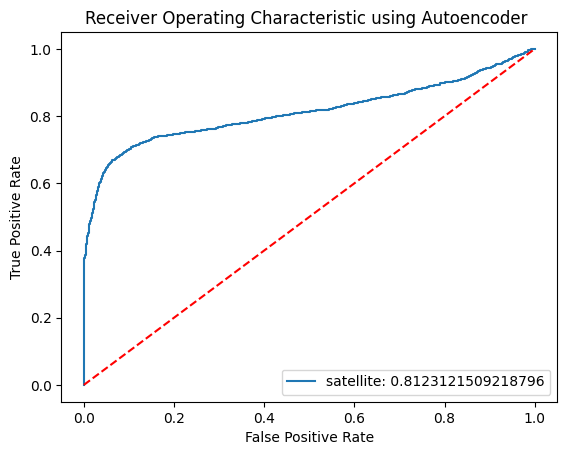

In [ ]:
test_satellite_3 = inspect_autoencoder(Autoencoder, latent_list = [16], data = [satellite], legend = ['satellite'], epochs = 200)

83/83 [==============================] - 0s 2ms/step


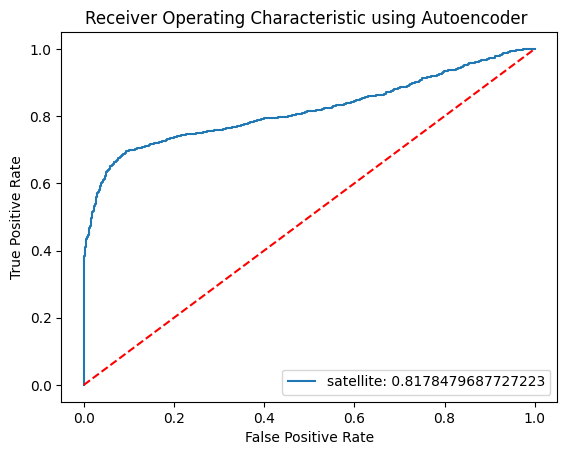

In [ ]:
test_satellite_4 = inspect_autoencoder(Autoencoder, latent_list = [16], data = [satellite], legend = ['satellite'], epochs = 300)

83/83 [==============================] - 0s 2ms/step


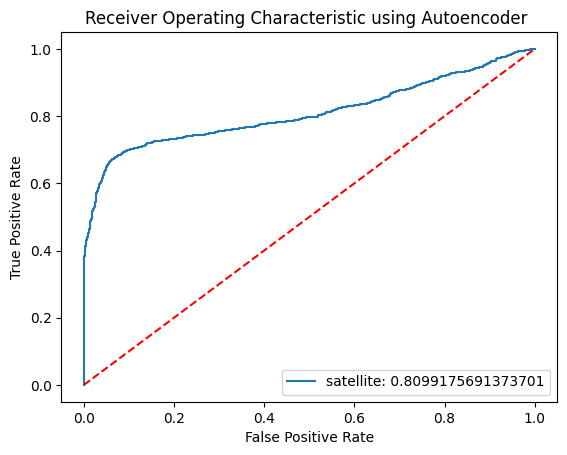

In [ ]:
test_satellite_5 = inspect_autoencoder(Autoencoder, latent_list = [16], data = [satellite], legend = ['satellite'], epochs = 1500)

## 5. Correlation between latent space and epochs

* we try to figure out the relationship between latent space and epochs in a model. 

In [ ]:
def latent_epochs(model_architecture, epoch_list: list, latent_list: list, data:list, legend:list, batch):
  """
  This function show us the influence of both latent space and epochs on AUS scores of trained models. Also we can see the correlation between latent and epochs through the changes of AUC scores 
  
  Arguments:
    model_architecture -- the model architecture that we want to use to create model
    data -- a list of datasets
    latent_list  - this contains the latent space of each dataset respectively
    legend -- name of datasets used to display on plot
    epoch_list -- a list of different epochs
  Returns:
    plot
    lat_epo -- this dictionary contains AUC score of each dataset according to each epoch value and latent space
  """
  # Set random seed
  tf.keras.utils.set_random_seed(42)
  lat_epo= {'dataset': legend, 'auc': [], 'latent': latent_list,'epochs': epoch_list}

  for n in range(len(data)):
    df = data[n]
    # extract X_train, X_test, y_test in df and scaled X_train, X_test
    X_train, X_test, y_test = extract_data(df)
    # list contains auc_score of trained models
    auc_list = []
    # training model with different sizes of latent space
    for i in range(len(epoch_list)):
      model, hist = training_model(model_architecture, X_train, X_test, latent = latent_list[i], loss = 'mse', epochs=epoch_list[i], batch_size=batch)

      #getting predictions (recontructions) of the test data
      preds = model.predict(X_test)
      # calculate the difference between predictions and test data using mean square error
      pred_errors = tf.keras.losses.mse(preds, X_test)
      # Check the prediction performance
      auc_score = roc_auc_score(y_test, pred_errors)
      auc_list.append(auc_score)

    lat_epo['auc'].append(auc_list)

  return lat_epo


In [ ]:
lat_epo = latent_epochs(Autoencoder, epoch_list=[50, 200, 500, 1000, 1500, 2000, 2500, 3000], latent_list = [4, 8, 16, 32, 64, 96, 112, 128], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'], batch=128)

83/83 [==============================] - 1s 10ms/step


In [ ]:
# create a dictionary contains all AUC scores of all datasets for each latent size value was used to train
latent_epo = {'latent_size': lat_epo['latent'],
              'epoch_size': lat_epo['epochs'],
               'cardio': lat_epo['auc'][0],
               'gas_drift': lat_epo['auc'][1],
               'satellite': lat_epo['auc'][2]}

latent_epo_df= pd.DataFrame.from_dict(latent_epo)
latent_epo_df

,latent_size,epoch_size,cardio,gas_drift,satellite
0,4,50,0.966200,0.853996,0.805766
1,8,200,0.908768,0.935828,0.790704
2,16,500,0.932012,0.963472,0.870251
3,32,1000,0.948250,0.989749,0.839979
4,64,1500,0.954093,0.994081,0.862075
5,96,2000,0.944635,0.994438,0.882142
6,112,2500,0.956418,0.994839,0.833466
7,128,3000,0.936176,0.994902,0.858932


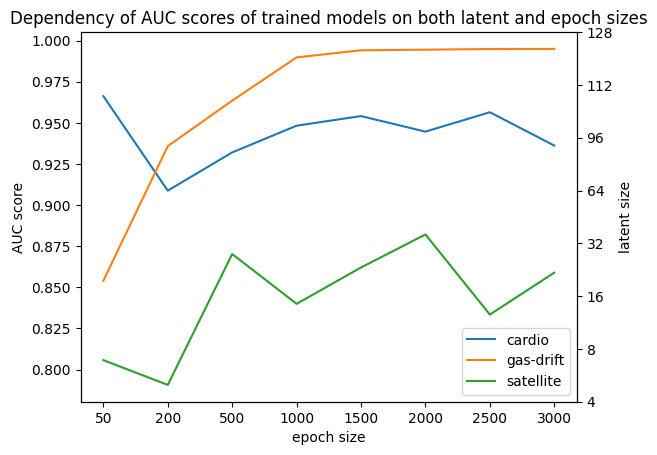

In [ ]:
# plot the effect of latent space on trained models
fig, axis = plt.subplots()
axis.plot(latent_epo_df.iloc[:, 2], label='cardio')
axis.plot(latent_epo_df.iloc[:, 3], label='gas-drift')
axis.plot(latent_epo_df.iloc[:, 4], label='satellite')
plt.xticks(ticks= [0, 1, 2, 3, 4, 5, 6, 7],labels=[50, 200, 500, 1000, 1500, 2000, 2500, 3000])
plt.legend(loc='best')
plt.title('Dependency of AUC scores of trained models on both latent and epoch sizes')
plt.xlabel("epoch size")
plt.ylabel('AUC score')
axis2 = axis.twiny()
plt.xlabel("latent size")
plt.xticks(ticks= [0, 1, 2, 3, 4, 5, 6, 7], labels=[4, 8, 16, 32, 64, 96, 112, 128])
plt.show()

* **From the graph, we can see that when training a model, if we increase the number of epochs, we should also increase latent size, so that we can get the better AUC score**

## 6.1. inspect the effect of ensemble model on datasets

* We inspect the correlation between AUC score and the ensembel model, which contains models with the same architecture, but `different random seed`
* we train with epochs=1500, batch_size=128
* best latent space for each dataset:

  * cardio: 64
  * gas-drift: 112
  * satellite: 96

In [ ]:
def inspect_ensemble(model_architecture, seed_list, latent_list: list, data:list, legend:list, epochs):
  """
  This function show us AUC score of datasets trained by using ensemble model. Ensemble model contains models with the same architecture, but different random seed
  
  Arguments:
    model_architecture -- the model architecture that we want to use to create model
    seed_list -- a list of numbers which are used to set random seed for the model
    latent_list -- this contains the best size of latent space for each dataset in data respectively
    data -- a list of datasets
    legend -- name of datasets used to display on plot
    epochs -- 
  Returns:
    plot
    ensemble_dict - this dictionary contains auc scores of datasets trained by ensemble model
  """
  ensemble_dict = {'dataset': legend, 'auc': []}

  for n in range(len(data)):
    df = data[n] # extract dataset n in data
    # extract X_train, X_test, y_test in df and scaled X_train, X_test
    X_train, X_test, y_test = extract_data(df)
    # create and train ensemble model for each dataset
    # list of pred_errors. Each element contains all the difference between inputs and their predictions of one model
    pred_errors_list = []

    for SEED in seed_list:
      # set random seed
      tf.keras.utils.set_random_seed(SEED)
      # create autoencoder model
      autoencoder, history = training_model(model_architecture, X_train, X_test, latent = latent_list[n], epochs=epochs)
      # getting predictions (recontructions) of the test data
      preds = autoencoder.predict(X_test)
      # calculate the difference between preds and test data using mean square error
      pred_errors = tf.keras.losses.mse(preds, X_test)
      # append pred_error to the pred_errors_list
      pred_errors_list.append(pred_errors)

    # convert pred_errors_list to a tensor
    preds_tensor = tf.convert_to_tensor(pred_errors_list)
    # calculate the average of all pred_errors in the pred_errors_list. We set axis=0, so that the average is calculated by row-weise
    avg_preds = tf.math.reduce_mean(preds_tensor, axis=0)
    auc_score = roc_auc_score(y_test, avg_preds)
    ensemble_dict['auc'].append(auc_score)

    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = roc_curve(y_test, avg_preds)
    plt.plot(fpr, tpr, label = f"{legend[n]}: {auc_score}")
    
  plt.legend(loc='lower right')
  plt.title('ROC of ensemble models')
  plt.plot([0, 1], [0, 1],'r--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  return ensemble_dict

83/83 [==============================] - 1s 6ms/step


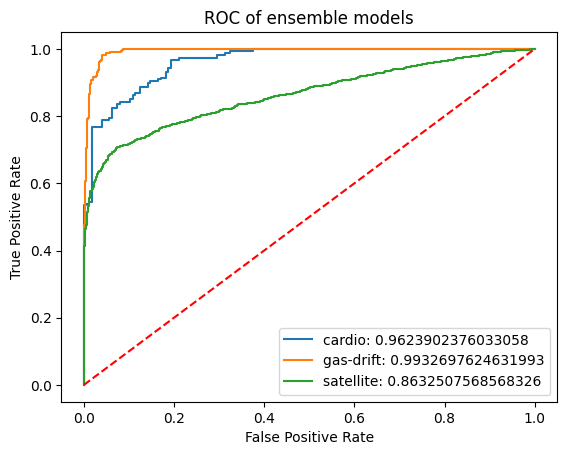

In [ ]:
ensemble_dict = inspect_ensemble(Autoencoder, [0, 7, 42, 24], [64, 112,96], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'], epochs = 1500 )

83/83 [==============================] - 0s 3ms/step


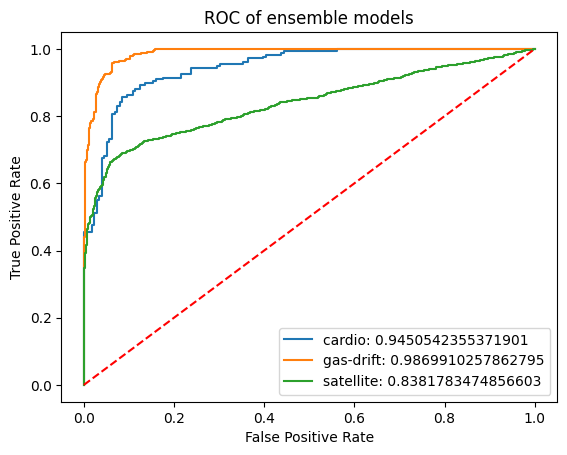

In [ ]:
ensemble_dict_2 = inspect_ensemble(Autoencoder, [0, 7, 42, 24], [4, 112, 64], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'], epochs = 500 )

83/83 [==============================] - 0s 4ms/step


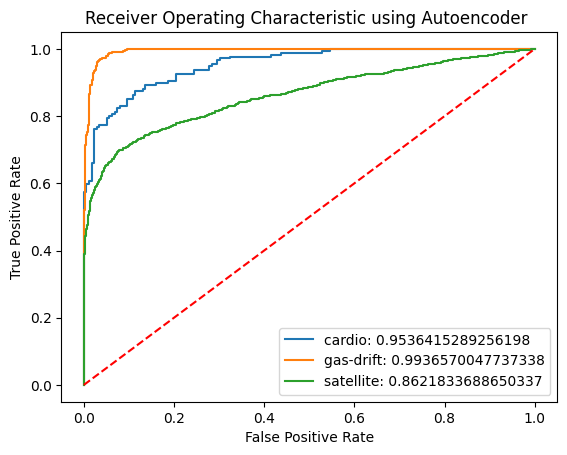

In [ ]:
# compare with Autoencoder
aut_dict_compare = inspect_autoencoder(Autoencoder, latent_list = [64, 112, 94], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'], epochs = 1500)

## 6.2. Correlation between AUC score and the number of Autoencoder in an ensemble model

In [ ]:
def ensemble_model(model_architecture, seed_list, X_train, X_test, y_test, latent, epochs, plot=True):
  """
  Create an ensemble model, which use an unique architecture, but with different numbers of random seed. 
  By setting a different random seed, we get a new model with the same architecture

  Arguments:
    model_architecture -- architecture of model, which is used to train model
    seed_list -- a list of numbers which are used to set random seed for the model
    X_train -- data which are used to train the model
    X_test -- data which are used to test the trained model
    y_test -- true labels of X_test
    plot -- True: plot the ROC curve. False: does not plot the ROC curve
         
  Returns: 
    avg_preds -- the average of predictions errors (the difference between inputs and their predictions) of all models in ensemble model
    auc_score -- the AUC score of ensemble model
    ROC curve
  """
  # list of pred_errors. Each element contains all the difference between inputs and their predictions of one model
  pred_errors_list = []

  for SEED in seed_list:
    # Set random seed
    tf.keras.utils.set_random_seed(SEED)
    # training model
    autoencoder, history = training_model(model_architecture, X_train, X_test, latent = latent, epochs=epochs)
    
    # getting predictions (recontructions) of the test data
    preds = autoencoder.predict(X_test)
    # calculate the difference between preds and test data using mean square error
    pred_errors = tf.keras.losses.mse(preds, X_test)
    # append pred_error to the pred_errors_list
    pred_errors_list.append(pred_errors)
  
  # convert pred_errors_list to a tensor
  preds_tensor = tf.convert_to_tensor(pred_errors_list)
  # calculate the average of all pred_errors in the pred_errors_list. We set axis=0, so that the average is calculated by row-weise. 
  avg_preds = tf.math.reduce_mean(preds_tensor, axis=0)
  # AUC score of the average pred_errors of all models vs. y_test
  auc_score = roc_auc_score(y_test, avg_preds)
  if not plot:
    print(f"AUC score: {auc_score}")
  else:
    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = roc_curve(y_test, avg_preds)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % auc_score)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
  
  return auc_score


In [ ]:
def plot_auc_models(model_architecture, num_models_list, latent_list: list, data:list, legend:list, epochs):
  """
  create a plot, showing how this final auc score of ensemble model depends on the number of models used.

  Arguments:
    model_architecture -- architecture of model, which is used to train model
    num_models_list -- a list contains the number of models which are integrated in one ensemble model
    latent_list -- this contains the best size of latent space for each dataset in data respectively
    data -- a list of datasets
    legend -- name of datasets used to display on plot
    epochs -- 
         
  Returns: 
    ROC curve
    num_auto -- a dictionary contains AUC score of each dataset according to each element in num_models_list
  """
  num_auto = {'dataset': legend, 'num_auto': num_models_list, 'auc':[]}
  for n in range(len(data)):
    df = data[n] # extract dataset n in data
    # extract X_train, X_test, y_test in df and scaled X_train, X_test
    X_train, X_test, y_test = extract_data(df)
    # list of auc score corresponding with the number of models integrated in an ensemble model
    AUC_LIST = []

    for i in num_models_list:
      # Create a random list of seed
      seed_list = np.random.randint(1000, size=i).tolist()
      # Get the auc_score of the ensemble model which is trained by using seed_list
      auc_score = ensemble_model(model_architecture, seed_list, X_train, X_test, y_test, latent_list[n], epochs, plot=False)
      AUC_LIST.append(auc_score)
    num_auto['auc'].append(AUC_LIST)
    # the plot display the correlation between auc score and the number of models integrated in an ensemble model
    plt.plot(num_models_list, AUC_LIST, label=legend[n])
  plt.title('Correlation between AUC score and the number of autoencoders in an ensemble model')
  plt.xlabel('the number of autoencoders in an ensemble model')
  plt.ylabel('AUC score of ensembel models')
  plt.legend(loc='best')
  plt.show()
  return num_auto


11/11 [==============================] - 0s 2ms/step
AUC score: 0.9620351239669421
11/11 [==============================] - 0s 2ms/step
AUC score: 0.9610020661157025
11/11 [==============================] - 0s 2ms/step
AUC score: 0.9607438016528925
11/11 [==============================] - 0s 2ms/step
AUC score: 0.9616800103305785
49/49 [==============================] - 0s 3ms/step
AUC score: 0.7609869436773815
49/49 [==============================] - 0s 3ms/step
AUC score: 0.7656871183591749
49/49 [==============================] - 0s 3ms/step
AUC score: 0.7772511207198309
49/49 [==============================] - 0s 3ms/step
AUC score: 0.7680469290331963
83/83 [==============================] - 0s 2ms/step
AUC score: 0.8322654663485386
83/83 [==============================] - 0s 2ms/step
AUC score: 0.8139727238396539
83/83 [==============================] - 0s 3ms/step
AUC score: 0.8131691651899313
83/83 [==============================] - 0s 2ms/step
AUC score: 0.8218766830616389


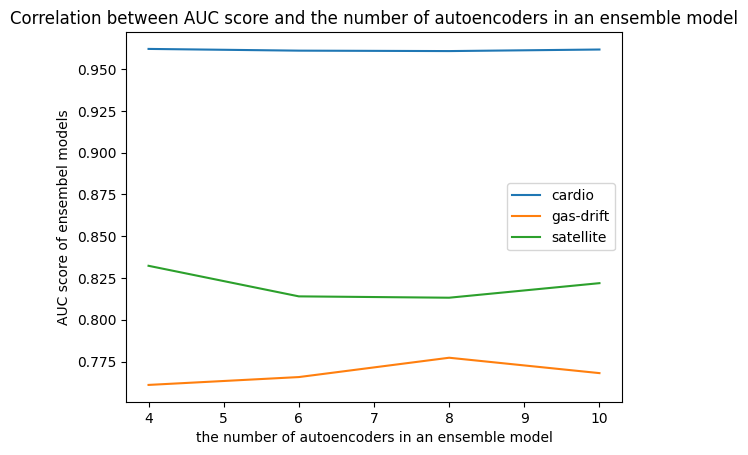

In [ ]:
num_auto_test = plot_auc_models(Autoencoder,[4, 6, 8, 10], latent_list = [64, 112, 94], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'], epochs = 3)

11/11 [==============================] - 0s 3ms/step
AUC score: 0.9602595557851239
11/11 [==============================] - 0s 2ms/step
AUC score: 0.9593233471074379
11/11 [==============================] - 0s 2ms/step
AUC score: 0.9605823863636364
11/11 [==============================] - 0s 2ms/step
AUC score: 0.9603886880165289
49/49 [==============================] - 0s 2ms/step
AUC score: 0.9947409450403392
49/49 [==============================] - 0s 2ms/step
AUC score: 0.9947866024306642
49/49 [==============================] - 0s 2ms/step
AUC score: 0.9932832905788511
49/49 [==============================] - 0s 2ms/step
AUC score: 0.9941710731685045
83/83 [==============================] - 0s 2ms/step
AUC score: 0.8603158709730819
83/83 [==============================] - 0s 2ms/step
AUC score: 0.8720215018039834
83/83 [==============================] - 0s 2ms/step
AUC score: 0.8715036145769448
83/83 [==============================] - 0s 2ms/step
AUC score: 0.8646957829265054


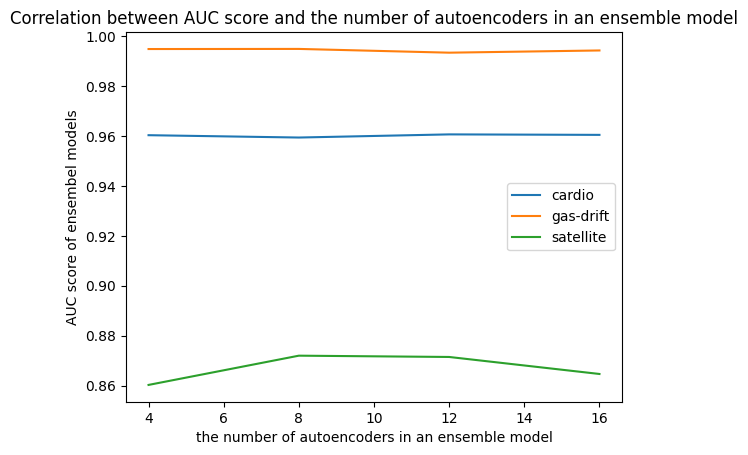

In [ ]:
# Epochs = 1500
num_auto_2 = plot_auc_models(Autoencoder,[4, 8, 12, 16], latent_list = [64, 112, 94], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'], epochs = 1500)

In [ ]:
# Create a DataFrame for num_auto
num_auto_dict = {'number of Autoencoders': num_auto_2['num_auto'],
                 'Cardio': num_auto_2['auc'][0],
                 'Gas-drift': num_auto_2['auc'][1],
                 'Satellite': num_auto_2['auc'][2]}
num_auto_df = pd.DataFrame.from_dict(num_auto_dict)
num_auto_df

,number of Autoencoders,Cardio,Gas-drift,Satellite
0,4,0.960260,0.994741,0.860316
1,8,0.959323,0.994787,0.872022
2,12,0.960582,0.993283,0.871504
3,16,0.960389,0.994171,0.864696


## 7. Inspect the effect of sequential_synchronizing on datasets

### a. AUC Score is calculated by using **the error predictions of the last sychronized model**

In [ ]:
def inspect_sequential_synchronizing(model_architecture, num_models, latent_list: list, data:list, legend:list, epochs, plot=True):
  """Create a sequential syschronizing ensemble, in which the error of the all previous models will be used as features in the data used to train the next model.
  AUC score is calculated by using the error predictions of the last sychronized model
  
  Arguments:
    model_architecture -- the model architecture that we want to use to create model
    num_models -- the number of models which are integrated in one sychronizing ensemble model
    latent_list -- this contains the best size of latent space for each dataset in data respectively
    data -- a list of datasets
    legend -- name of datasets used to display on plot
    epochs -- 
  Returns:
    sesyn_dict -- this contains the auc score of each dataset in data
    plot
  """
  # Set random seed
  tf.keras.utils.set_random_seed(42)
  sesyn_dict = {'dataset': legend, 'auc': []}

  for n in range(len(data)):
    df = data[n] # extract dataset n in data
    # extract X_train, X_test, y_test in df and scaled X_train, X_test
    X_train, X_test, y_test = extract_data(df)
    
    # list of pred_errors. Each element contains all the difference between training data and their predictions of one model
    avg_pred_errors_list = []
    # list of test_errors. Each element contains all the difference between test data and their predictions on one model
    test_errors_list = []
    X = X_train.copy()
    X_te = X_test.copy()
    auc_list = []  # this list saves the AUC score of each model during training process

    for i in range(num_models):
      # 1. Create model
      # if pred_errors_list is not empty, then we have to concatenate the element at position i-1 to the current training input
      if avg_pred_errors_list:
        # convert the element at position i-1 in pred_errors_list to a 2D-tensor and then convert it to a numpy array. 
        pred_current = tf.reshape(avg_pred_errors_list[i-1], [-1, 1]).numpy()
        # convert the element at position i-1 in test_errors_list to a 2D-tensor and then convert it to a numpy array.
        pred_test_current = tf.reshape(test_errors_list[i-1], [-1, 1]).numpy()
        # concatenate the pred_current to X
        X = np.concatenate((X, pred_current), axis=1)
        # concatenate the pred_current to X_test also. This new X_test will be used for later predict method   
        X_te = np.concatenate((X_te, pred_test_current), axis=1)

      # training model
      autoencoder, history = training_model(model_architecture, X, X_te, latent = latent_list[n], verbose = 0, loss = "mse", epochs=epochs, batch_size=128)

      # getting predictions (recontructions) of the training data
      preds = autoencoder.predict(X)
      # calculate the difference between preds and the training data using (input - preds)**2
      pred_errors = tf.math.square(tf.math.subtract(preds, X))
      # calculate the average of pred_errors. We set axis = 1, so that the average is calculated by column-weise
      avg_preds = tf.math.reduce_mean(pred_errors, axis=1)   # shape = (X_train.shape[1], 1)
      # append avg_preds to the avg_pred_errors_list
      avg_pred_errors_list.append(avg_preds)

      # getting predictions (recontructions) of the test data
      preds_test = autoencoder.predict(X_te)
      # calculate the difference between preds and the test data using (input - preds)**2. These values is used to create a new feature added to the next training loop
      pred_errors_test = tf.math.square(tf.math.subtract(preds_test, X_te))
      # calculate the average of pred_errors_test. We set axis = 1, so that the average is calculated by column-weise
      avg_preds_test = tf.math.reduce_mean(pred_errors_test, axis=1)   # shape = (X_train.shape[1], 1)
      # append avg_preds_test to the test_errors_list
      test_errors_list.append(avg_preds_test)

      # 4. Calculating AUC score of each training model 
      auc_score = roc_auc_score(y_test, avg_preds_test)
      auc_list.append(auc_score)
      
    sesyn_dict['auc'].append(auc_list)
  return sesyn_dict

In [ ]:
se_syn= inspect_sequential_synchronizing(Autoencoder, 10, latent_list= [64, 112, 96], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'], epochs = 1500)

83/83 [==============================] - 0s 6ms/step


In [ ]:
se_sy_dict = {'number of models': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'cardio': se_syn['auc'][0],
              'gas_drift': se_syn['auc'][1],
              'satellite': se_syn['auc'][2]}

se_sy_df= pd.DataFrame.from_dict(se_sy_dict)
se_sy_df

,number of models,cardio,gas_drift,satellite
0,1,0.953642,0.994503,0.854225
1,2,0.943634,0.996160,0.866846
2,3,0.947701,0.994323,0.852862
3,4,0.948283,0.994873,0.845072
4,5,0.965748,0.994244,0.874867
5,6,0.953060,0.993424,0.863992
6,7,0.956612,0.990985,0.837843
7,8,0.963552,0.992658,0.863615
8,9,0.962487,0.994103,0.854262
9,10,0.954707,0.993143,0.858683


### b.  AUC score is calculated by using **the average value of all error predictions from all previous sychronized model**

In [ ]:
def inspect_sequential(model_architecture, num_models, latent_list: list, data:list, legend:list, epochs, plot=True):
  """Create a sequential syschronizing ensemble, in which the error of the all previous models will be used as features in the data used to train the next model.
  AUC score is calculated by using the average value of all error predictions from all previous sychronized model
  
  Arguments:
    model_architecture -- the model architecture that we want to use to create model
    num_models -- the number of models which are integrated in one sychronizing ensemble model
    latent_list -- this contains the best size of latent space for each dataset in data respectively
    data -- a list of datasets
    legend -- name of datasets used to display on plot
    epochs -- 
  Returns:
    sesyn_dict -- this contains the auc score of each dataset in data
    plot
  """
  # Set random seed
  tf.keras.utils.set_random_seed(42)
  sesyn_dict = {'dataset': legend, 'auc': []}

  for n in range(len(data)):
    df = data[n] # extract dataset n in data
    # extract X_train, X_test, y_test in df and scaled X_train, X_test
    X_train, X_test, y_test = extract_data(df)
    
    # list of pred_errors. Each element contains all the difference between training data and their predictions of one model
    avg_pred_errors_list = []
    # list of test_errors. Each element contains all the difference between test data and their predictions on one model
    test_errors_list = []
    X = X_train.copy()
    X_te = X_test.copy()
    auc_list = []  # this list saves the AUC score of each model during training process

    for i in range(num_models):
      # 1. Create model
      # if pred_errors_list is not empty, then we have to concatenate the element at position i-1 to the current training input
      if avg_pred_errors_list:
        # convert the element at position i-1 in pred_errors_list to a 2D-tensor and then convert it to a numpy array. 
        pred_current = tf.reshape(avg_pred_errors_list[i-1], [-1, 1]).numpy()
        # convert the element at position i-1 in test_errors_list to a 2D-tensor and then convert it to a numpy array.
        pred_test_current = tf.reshape(test_errors_list[i-1], [-1, 1]).numpy()
        # concatenate the pred_current to X
        X = np.concatenate((X, pred_current), axis=1)
        # concatenate the pred_current to X_test also. This new X_test will be used for later predict method   
        X_te = np.concatenate((X_te, pred_test_current), axis=1)

      # training model
      autoencoder, history = training_model(model_architecture, X, X_te, latent = latent_list[n], verbose = 0, loss = "mse", epochs=epochs, batch_size=128)

      # getting predictions (recontructions) of the training data
      preds = autoencoder.predict(X)
      # calculate the difference between preds and the training data using (input - preds)**2
      pred_errors = tf.math.square(tf.math.subtract(preds, X))
      # calculate the average of pred_errors. We set axis = 1, so that the average is calculated by column-weise
      avg_preds = tf.math.reduce_mean(pred_errors, axis=1)   # shape = (X_train.shape[1], 1)
      # append avg_preds to the avg_pred_errors_list
      avg_pred_errors_list.append(avg_preds)

      # getting predictions (recontructions) of the test data
      preds_test = autoencoder.predict(X_te)
      # calculate the difference between preds and the test data using (input - preds)**2. These values is used to create a new feature added to the next training loop
      pred_errors_test = tf.math.square(tf.math.subtract(preds_test, X_te))
      # calculate the average of pred_errors_test. We set axis = 1, so that the average is calculated by column-weise
      avg_preds_test = tf.math.reduce_mean(pred_errors_test, axis=1)   # shape = (X_train.shape[1], 1)
      # append avg_preds_test to the test_errors_list
      test_errors_list.append(avg_preds_test)
      # calculate the average of all elements in test_errors_list up to index i. This average value is used to calculate AUC Scores
      tensor_errors_list  = tf.reshape(tf.math.reduce_mean(tf.convert_to_tensor(test_errors_list), axis=0), [y_test.shape[0], 1])

      # 4. Calculating AUC score of each training model 
      #avg_test_errors_list = 
      auc_score = roc_auc_score(y_test, tensor_errors_list)
      auc_list.append(auc_score)
      
    sesyn_dict['auc'].append(auc_list)
  return sesyn_dict

In [ ]:
sequential_dict = inspect_sequential(Autoencoder, 10, latent_list= [64, 112, 96], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'], epochs = 1500)

83/83 [==============================] - 0s 2ms/step


In [ ]:
sequential = {'number of models': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'cardio': sequential_dict['auc'][0],
              'gas_drift': sequential_dict['auc'][1],
              'satellite': sequential_dict['auc'][2]}

sequential_dict_df= pd.DataFrame.from_dict(sequential)
sequential_dict_df

,number of models,cardio,gas_drift,satellite
0,1,0.956644,0.992475,0.861207
1,2,0.960098,0.992986,0.863731
2,3,0.961680,0.993356,0.860931
3,4,0.959775,0.993471,0.861784
4,5,0.963488,0.993698,0.864708
5,6,0.962745,0.993955,0.861337
6,7,0.961325,0.994149,0.863970
7,8,0.960389,0.993965,0.864173
8,9,0.960873,0.994071,0.863367
9,10,0.961648,0.994139,0.862306


## 8. drop_synchronizing_ensemble

only the prediction errors of the last trained model are used as a feature in the data used to train the next model

### a. AUC score is calculated by using **the error predictions of the last sychronized model**

In [ ]:
def inspect_drop_synchronizing(model_architecture, num_models, latent_list: list, data:list, legend:list, epochs, plot=True):
  """Create a syschronizing ensemble, in which the prediction errors of the last 
  trained model will be added as an feature to the original training data used for the next model.
  AUC score is calculated by using the error predictions of the last sychronized model
  
  Arguments:
    model_architecture -- the model architecture that we want to use to create model
    num_models -- the number of models which are integrated in one sychronizing ensemble model
    latent_list -- this contains the best size of latent space for each dataset in data respectively
    data -- a list of datasets
    legend -- name of datasets used to display on plot
    epochs -- 
  Returns:
    dropsyn_dict -- this contains the auc score of each dataset in data
    plot
  """
  # Set random seed
  tf.keras.utils.set_random_seed(42)
  dropsyn_dict = {'dataset': legend, 'auc': []}

  for n in range(len(data)):
    df = data[n] # extract dataset n in data
    # extract X_train, X_test, y_test in df and scaled X_train, X_test
    X_train, X_test, y_test = extract_data(df)

    # list of pred_errors. Each element contains all the difference between inputs and their predictions of one model
    avg_pred_errors_list = []
    test_errors_list = []
    auc_score_list = []
    X_plus_one = X_train.copy()
    X_test_one = X_test.copy()
    auc_list = []  # this list saves the AUC score of each model during training process

    for i in range(num_models):
      # 1. Create model
      # if pred_errors_list is not empty, then we have to concatenate the element at position i to the current training input
      if avg_pred_errors_list:
        # convert the element at position i-1 in pred_errors_list to a 2D-tensor and then convert it to a numpy array. 
        pred_current = tf.reshape(avg_pred_errors_list[i-1], [-1, 1]).numpy()
        # only the prediction errors of the last model is concatenated to the original training data before training the next one
        X_plus_one = np.concatenate((X_train.copy(), pred_current), axis=1)
        # convert the element at position i-1 in test_errors_list to a 2D-tensor and then convert it to a numpy array. 
        pred_test_current = tf.reshape(test_errors_list[i-1], [-1, 1]).numpy()
        # concatenate the pred_current to X_test also. This new X_test will be used for later predict method   
        X_test_one = np.concatenate((X_test.copy(), pred_test_current), axis=1)
      
      # training model
      autoencoder, history = training_model(model_architecture, X_plus_one, X_test_one, latent = latent_list[n], verbose = 0, loss = "mse", epochs=epochs, batch_size=128)
      
      # getting predictions of the training data
      preds = autoencoder.predict(X_plus_one)
      # calculate the difference between preds and the training data using (input - preds)**2
      pred_errors = tf.math.square(tf.math.subtract(preds, X_plus_one))
      # calculate the average of pred_errors. We set axis = 1, so that the average is calculated by column-weise
      avg_preds = tf.math.reduce_mean(pred_errors, axis=1)   # shape = (X_train.shape[1], 1)
      # append avg_preds to the avg_pred_errors_list
      avg_pred_errors_list.append(avg_preds)

      # getting predictions (recontructions) of the test data
      preds_test = autoencoder.predict(X_test_one)
      # calculate the difference between preds and the test data using (input - preds)**2. These values is used to create a new feature added to the next training loop
      pred_errors_test = tf.math.square(tf.math.subtract(preds_test, X_test_one))
      # calculate the average of pred_errors_test. We set axis = 1, so that the average is calculated by column-weise
      avg_preds_test = tf.math.reduce_mean(pred_errors_test, axis=1)   # shape = (X_train.shape[1], 1)
      # append avg_preds_test to the test_errors_list
      test_errors_list.append(avg_preds_test)

      # 4. Calculating AUC score of each training model 
      auc_score = roc_auc_score(y_test, avg_preds_test)
      auc_list.append(auc_score)
      
    dropsyn_dict['auc'].append(auc_list)
  return dropsyn_dict

In [ ]:
dropsyn_dict = inspect_drop_synchronizing(Autoencoder, 10, latent_list= [64, 112, 96], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'], epochs = 1500)

83/83 [==============================] - 0s 4ms/step


In [ ]:
dropsyn = {'number of models': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'cardio': dropsyn_dict['auc'][0],
              'gas_drift': dropsyn_dict['auc'][1],
              'satellite': dropsyn_dict['auc'][2]}

dropsyn_df = pd.DataFrame.from_dict(dropsyn)
dropsyn_df

,number of models,cardio,gas_drift,satellite
0,1,0.953642,0.994503,0.854225
1,2,0.943634,0.996160,0.866846
2,3,0.947927,0.994242,0.880959
3,4,0.944828,0.994768,0.845577
4,5,0.946281,0.993850,0.860131
5,6,0.960001,0.993552,0.855761
6,7,0.973431,0.991711,0.854957
7,8,0.961841,0.994267,0.881420
8,9,0.944344,0.994120,0.860253
9,10,0.924845,0.992906,0.863777


### b. AUC score is calculated by using **the average value of all error predictions from all previous sychronized model**
  

In [ ]:
def inspect_drop(model_architecture, num_models, latent_list: list, data:list, legend:list, epochs, plot=True):
  """Create a syschronizing ensemble, in which the prediction errors of the last 
  trained model will be added as an feature to the original training data used for the next model.
  AUC score is calculated by using the prediction errors of all trained models
  
  Arguments:
    model_architecture -- the model architecture that we want to use to create model
    num_models -- the number of models which are integrated in one sychronizing ensemble model
    latent_list -- this contains the best size of latent space for each dataset in data respectively
    data -- a list of datasets
    legend -- name of datasets used to display on plot
    epochs -- 
  Returns:
    dropsyn_dict -- this contains the auc score of each dataset in data
    plot
  """
  # Set random seed
  tf.keras.utils.set_random_seed(42)
  dropsyn_dict = {'dataset': legend, 'auc': []}

  for n in range(len(data)):
    df = data[n] # extract dataset n in data
    # extract X_train, X_test, y_test in df and scaled X_train, X_test
    X_train, X_test, y_test = extract_data(df)

    # list of pred_errors. Each element contains all the difference between inputs and their predictions of one model
    avg_pred_errors_list = []
    test_errors_list = []
    auc_score_list = []
    X_plus_one = X_train.copy()
    X_test_one = X_test.copy()
    auc_list = []  # this list saves the AUC score of each model during training process

    for i in range(num_models):
      # 1. Create model
      # if pred_errors_list is not empty, then we have to concatenate the element at position i to the current training input
      if avg_pred_errors_list:
        # convert the element at position i-1 in pred_errors_list to a 2D-tensor and then convert it to a numpy array. 
        pred_current = tf.reshape(avg_pred_errors_list[i-1], [-1, 1]).numpy()
        # only the prediction errors of the last model is concatenated to the original training data before training the next one
        X_plus_one = np.concatenate((X_train.copy(), pred_current), axis=1)
        # convert the element at position i-1 in test_errors_list to a 2D-tensor and then convert it to a numpy array. 
        pred_test_current = tf.reshape(test_errors_list[i-1], [-1, 1]).numpy()
        # concatenate the pred_current to X_test also. This new X_test will be used for later predict method   
        X_test_one = np.concatenate((X_test.copy(), pred_test_current), axis=1)
      
      # training model
      autoencoder, history = training_model(model_architecture, X_plus_one, X_test_one, latent = latent_list[n], verbose = 0, loss = "mse", epochs=epochs, batch_size=128)
      
      # getting predictions of the training data
      preds = autoencoder.predict(X_plus_one)
      # calculate the difference between preds and the training data using (input - preds)**2
      pred_errors = tf.math.square(tf.math.subtract(preds, X_plus_one))
      # calculate the average of pred_errors. We set axis = 1, so that the average is calculated by column-weise
      avg_preds = tf.math.reduce_mean(pred_errors, axis=1)   # shape = (X_train.shape[1], 1)
      # append avg_preds to the avg_pred_errors_list
      avg_pred_errors_list.append(avg_preds)

      # getting predictions (recontructions) of the test data
      preds_test = autoencoder.predict(X_test_one)
      # calculate the difference between preds and the test data using (input - preds)**2. These values is used to create a new feature added to the next training loop
      pred_errors_test = tf.math.square(tf.math.subtract(preds_test, X_test_one))
      # calculate the average of pred_errors_test. We set axis = 1, so that the average is calculated by column-weise
      avg_preds_test = tf.math.reduce_mean(pred_errors_test, axis=1)   # shape = (X_train.shape[1], 1)
      # append avg_preds_test to the test_errors_list
      test_errors_list.append(avg_preds_test)

      # calculate the average of all elements in test_errors_list up to index i. This average value is used to calculate AUC Scores
      tensor_errors_list  = tf.reshape(tf.math.reduce_mean(tf.convert_to_tensor(test_errors_list), axis=0), [-1, 1])
      # 4. Calculating AUC score of each training model 
      auc_score = roc_auc_score(y_test, tensor_errors_list)
      auc_list.append(auc_score)
      
    dropsyn_dict['auc'].append(auc_list)
  return dropsyn_dict

In [ ]:
drop_dict = inspect_drop(Autoencoder, 10, latent_list= [64, 112, 96], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'], epochs = 1500)

83/83 [==============================] - 0s 2ms/step


In [ ]:
dropsyn_2 = {'number of models': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'cardio': drop_dict['auc'][0],
              'gas_drift': drop_dict['auc'][1],
              'satellite': drop_dict['auc'][2]}

drop_df = pd.DataFrame.from_dict(dropsyn_2)
drop_df

,number of models,cardio,gas_drift,satellite
0,1,0.959033,0.994797,0.859344
1,2,0.963552,0.994249,0.855966
2,3,0.962229,0.994653,0.858487
3,4,0.962939,0.994431,0.861571
4,5,0.962035,0.994010,0.862408
5,6,0.961712,0.994494,0.860780
6,7,0.960712,0.994430,0.862663
7,8,0.962649,0.994526,0.861691
8,9,0.962455,0.994557,0.859513
9,10,0.962423,0.994602,0.861501


## 9. Using **Sequential model**:

* Use Sequential model to train 10 different sequential models for each dataset. These sequential models are differentiated by **random seed**
* Then calculate the mean and standard deviation AUC scores of 10 models for each dataset

### 9.a. Using the full sequential models:

* A sequential syschronizing ensemble, in which the error of the **all previous models** will be used as features in the data used to train the next model.
* AUC score is calculated by using the average value of all error predictions from all previous sychronized model

In [ ]:
def full_sequential(model_architecture, num_models, latent_list: list, data:list, legend:list, seed_list: list, epochs):
  """Create a sequential syschronizing ensemble, in which the error of the all previous models will be used as features in the data used to train the next model.
  AUC score is calculated by using the average value of all error predictions from all previous sychronized model
  
  Arguments:
    model_architecture -- the model architecture that we want to use to create model
    num_models -- the number of models which are integrated in one sychronizing ensemble model
    latent_list -- this contains the best size of latent space for each dataset in data respectively
    data -- a list of datasets
    legend -- name of datasets used to display on plot
    seed -- the random seed
    epochs -- 
  Returns:
    full_sequential_dict -- this contains the auc score list of each dataset in data according to each seed
  """
  full_sequential_dict = {'dataset': legend, 'seed': seed_list, 'auc': []}
  for seed in seed_list:
    # Set random seed
    tf.keras.utils.set_random_seed(seed)
    sesyn_auc = []

    for n in range(len(data)):
      df = data[n] # extract dataset n in data
      # extract X_train, X_test, y_test in df and scaled X_train, X_test
      X_train, X_test, y_test = extract_data(df)
      
      # list of pred_errors. Each element contains all the difference between training data and their predictions of one model
      avg_pred_errors_list = []
      # list of test_errors. Each element contains all the difference between test data and their predictions on one model
      test_errors_list = []
      X = X_train.copy()
      X_te = X_test.copy()
      auc_list = []  # this list saves the AUC score of each model during training process

      for i in range(num_models):
        # 1. Create model
        # if pred_errors_list is not empty, then we have to concatenate the element at position i-1 to the current training input
        if avg_pred_errors_list:
          # convert the element at position i-1 in pred_errors_list to a 2D-tensor and then convert it to a numpy array. 
          pred_current = tf.reshape(avg_pred_errors_list[i-1], [-1, 1]).numpy()
          # convert the element at position i-1 in test_errors_list to a 2D-tensor and then convert it to a numpy array.
          pred_test_current = tf.reshape(test_errors_list[i-1], [-1, 1]).numpy()
          # concatenate the pred_current to X
          X = np.concatenate((X, pred_current), axis=1)
          # concatenate the pred_current to X_test also. This new X_test will be used for later predict method   
          X_te = np.concatenate((X_te, pred_test_current), axis=1)

        # training model
        autoencoder, history = training_model(model_architecture, X, X_te, latent = latent_list[n], verbose = 0, loss = "mse", epochs=epochs, batch_size=128)

        # getting predictions (recontructions) of the training data
        preds = autoencoder.predict(X)
        # calculate the difference between preds and the training data using (input - preds)**2
        pred_errors = tf.math.square(tf.math.subtract(preds, X))
        # calculate the average of pred_errors. We set axis = 1, so that the average is calculated by column-weise
        avg_preds = tf.math.reduce_mean(pred_errors, axis=1)   # shape = (X_train.shape[1], 1)
        # append avg_preds to the avg_pred_errors_list
        avg_pred_errors_list.append(avg_preds)

        # getting predictions (recontructions) of the test data
        preds_test = autoencoder.predict(X_te)
        # calculate the difference between preds and the test data using (input - preds)**2. These values is used to create a new feature added to the next training loop
        pred_errors_test = tf.math.square(tf.math.subtract(preds_test, X_te))
        # calculate the average of pred_errors_test. We set axis = 1, so that the average is calculated by column-weise
        avg_preds_test = tf.math.reduce_mean(pred_errors_test, axis=1)   # shape = (X_train.shape[1], 1)
        # append avg_preds_test to the test_errors_list
        test_errors_list.append(avg_preds_test)
        # calculate the average of all elements in test_errors_list up to index i. This average value is used to calculate AUC Scores
        tensor_errors_list  = tf.reshape(tf.math.reduce_mean(tf.convert_to_tensor(test_errors_list), axis=0), [y_test.shape[0], 1])

        # 4. Calculating AUC score of each training model 
        #avg_test_errors_list = 
        auc_score = roc_auc_score(y_test, tensor_errors_list)
        auc_list.append(auc_score)
        
      sesyn_auc.append(auc_list)
    full_sequential_dict['auc'].append(sesyn_auc)
  return full_sequential_dict

In [ ]:
full_sequential = full_sequential(Autoencoder, 10, latent_list= [64, 112, 96], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'],seed_list = [1, 3, 42, 7, 10, 100, 123, 9, 50, 142], epochs = 1500)

TypeError: ignored

In [ ]:
# extract AUC scores of each dataset from full_sequential
cardio_auc = [full_sequential['auc'][i][0] for i in range(0, 10)]
gas_drift_auc = [full_sequential['auc'][i][1] for i in range(0, 10)]
satellite_auc = [full_sequential['auc'][i][2] for i in range(0, 10)]



In [ ]:
# calculate mean of AUC score list
cardio_mean = np.mean(np.array(cardio_auc), axis=0)
gas_drift_mean = np.mean(np.array(gas_drift_auc), axis=0)
satellite_mean = np.mean(np.array(satellite_auc), axis=0)

# calculate standard deviation of AUC score list of each dataset
cardio_std = np.std(np.array(cardio_auc), axis=0)
gas_drift_std = np.std(np.array(gas_drift_auc), axis=0)
satellite_std = np.std(np.array(satellite_auc), axis=0)

In [ ]:
full_sequential_dict = {'cardio mean': cardio_mean,
                        'cardio std': cardio_std,
                        'gas-drift mean': gas_drift_mean,
                        'gas-drift std': gas_drift_std,
                        'satellite mean': satellite_mean,
                        'satellite std': satellite_std}
full_sequential_df = pd.DataFrame.from_dict(full_sequential_dict)
full_sequential_df     # this dataframe is the result of training 10 different full_sequential models, which are a combination of 10 autoencoder models               

,cardio mean,cardio std,gas-drift mean,gas-drift std,satellite mean,satellite std
0,0.954888,0.008175,0.994218,0.000866,0.853125,0.006988
1,0.958978,0.004946,0.994122,0.000827,0.859788,0.007497
2,0.960379,0.004216,0.994407,0.000612,0.863146,0.008951
3,0.960415,0.002812,0.994210,0.000507,0.864938,0.008411
4,0.962335,0.002615,0.994184,0.000503,0.864238,0.007734
5,0.961638,0.002465,0.994175,0.000388,0.865529,0.006491
6,0.962142,0.002608,0.994225,0.000294,0.865228,0.005874
7,0.962364,0.002242,0.994289,0.000264,0.864858,0.005831
8,0.962761,0.002194,0.994300,0.000269,0.864221,0.005216
9,0.962571,0.002161,0.994279,0.000287,0.864212,0.004572


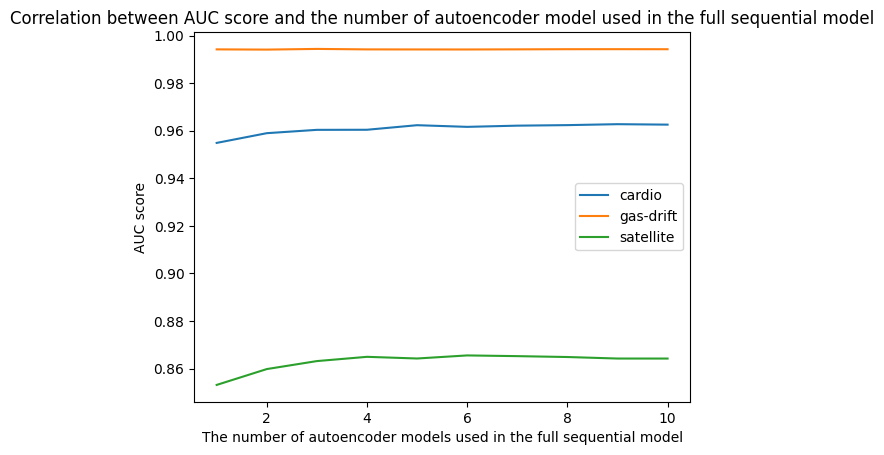

In [ ]:
# plot AUC score mean of each dataset according to the number of models in the sequential 
x = [i for i in range(1, 11)]
plt.plot(x, cardio_mean, label='cardio')
plt.plot(x, gas_drift_mean, label='gas-drift')
plt.plot(x, satellite_mean, label='satellite')
plt.title('Correlation between AUC score and the number of autoencoder model used in the full sequential model')
plt.xlabel('The number of autoencoder models used in the full sequential model')
plt.ylabel('AUC score')
plt.legend(loc='best')
plt.show()

### 9.b. Using drop sequential model

* a syschronizing ensemble, in which the prediction errors of **the last  trained model** will be added as **an feature** to the original training data used for the next model.
* AUC score is calculated by using the average value of all error predictions from all previous sychronized model

In [ ]:
def drop_sequential(model_architecture, num_models, latent_list: list, data:list, legend:list, seed_list, epochs):
  """Create a syschronizing ensemble, in which the prediction errors of the last 
  trained model will be added as an feature to the original training data used for the next model.
  AUC score is calculated by using the error predictions of the last sychronized model
  
  Arguments:
    model_architecture -- the model architecture that we want to use to create model
    num_models -- the number of models which are integrated in one sychronizing ensemble model
    latent_list -- this contains the best size of latent space for each dataset in data respectively
    data -- a list of datasets
    legend -- name of datasets used to display on plot
    seed_list
    epochs -- 
  Returns:
    drop_sequential_dict -- this contains the auc score list of each dataset in data according to each seed

  """
  drop_sequential_dict = {'dataset': legend, 'seed': seed_list, 'auc': []}
  for seed in seed_list:
    # Set random seed
    tf.keras.utils.set_random_seed(seed)
    dropsyn = []

    for n in range(len(data)):
      df = data[n] # extract dataset n in data
      # extract X_train, X_test, y_test in df and scaled X_train, X_test
      X_train, X_test, y_test = extract_data(df)

      # list of pred_errors. Each element contains all the difference between inputs and their predictions of one model
      avg_pred_errors_list = []
      test_errors_list = []
      auc_score_list = []
      X_plus_one = X_train.copy()
      X_test_one = X_test.copy()
      auc_list = []  # this list saves the AUC score of each model during training process

      for i in range(num_models):
        # 1. Create model
        # if pred_errors_list is not empty, then we have to concatenate the element at position i to the current training input
        if avg_pred_errors_list:
          # convert the element at position i-1 in pred_errors_list to a 2D-tensor and then convert it to a numpy array. 
          pred_current = tf.reshape(avg_pred_errors_list[i-1], [-1, 1]).numpy()
          # only the prediction errors of the last model is concatenated to the original training data before training the next one
          X_plus_one = np.concatenate((X_train.copy(), pred_current), axis=1)
          # convert the element at position i-1 in test_errors_list to a 2D-tensor and then convert it to a numpy array. 
          pred_test_current = tf.reshape(test_errors_list[i-1], [-1, 1]).numpy()
          # concatenate the pred_current to X_test also. This new X_test will be used for later predict method   
          X_test_one = np.concatenate((X_test.copy(), pred_test_current), axis=1)
        
        # training model
        autoencoder, history = training_model(model_architecture, X_plus_one, X_test_one, latent = latent_list[n], verbose = 0, loss = "mse", epochs=epochs, batch_size=128)
        
        # getting predictions of the training data
        preds = autoencoder.predict(X_plus_one)
        # calculate the difference between preds and the training data using (input - preds)**2
        pred_errors = tf.math.square(tf.math.subtract(preds, X_plus_one))
        # calculate the average of pred_errors. We set axis = 1, so that the average is calculated by column-weise
        avg_preds = tf.math.reduce_mean(pred_errors, axis=1)   # shape = (X_train.shape[1], 1)
        # append avg_preds to the avg_pred_errors_list
        avg_pred_errors_list.append(avg_preds)

        # getting predictions (recontructions) of the test data
        preds_test = autoencoder.predict(X_test_one)
        # calculate the difference between preds and the test data using (input - preds)**2. These values is used to create a new feature added to the next training loop
        pred_errors_test = tf.math.square(tf.math.subtract(preds_test, X_test_one))
        # calculate the average of pred_errors_test. We set axis = 1, so that the average is calculated by column-weise
        avg_preds_test = tf.math.reduce_mean(pred_errors_test, axis=1)   # shape = (X_train.shape[1], 1)
        # append avg_preds_test to the test_errors_list
        test_errors_list.append(avg_preds_test)

        # calculate the average of all elements in test_errors_list up to index i. This average value is used to calculate AUC Scores
        tensor_errors_list  = tf.reshape(tf.math.reduce_mean(tf.convert_to_tensor(test_errors_list), axis=0), [-1, 1])
        # 4. Calculating AUC score of each training model 
        auc_score = roc_auc_score(y_test, tensor_errors_list)
        auc_list.append(auc_score)
        
      dropsyn.append(auc_list)
    drop_sequential_dict['auc'].append(dropsyn)
  return drop_sequential_dict

In [ ]:
drop_sequential_4 = drop_sequential(Autoencoder, 10, latent_list= [64, 112, 96], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'],seed_list = [1, 3, 42, 7, 10, 100, 123, 9, 50, 142], epochs = 1500)

83/83 [==============================] - 0s 2ms/step


In [ ]:
# extract AUC scores of each dataset from drop_sequential_3
drop_cardio_auc = [drop_sequential_4['auc'][i][0] for i in range(0, 10)]
drop_gas_drift_auc = [drop_sequential_4['auc'][i][1] for i in range(0, 10)]
drop_satellite_auc = [drop_sequential_4['auc'][i][2] for i in range(0, 10)]

In [ ]:
# calculate mean of AUC score list
drop_cardio_mean = np.mean(np.array(drop_cardio_auc), axis=0)
drop_gas_drift_mean = np.mean(np.array(drop_gas_drift_auc), axis=0)
drop_satellite_mean = np.mean(np.array(drop_satellite_auc), axis=0)

# calculate standard deviation of AUC score list of each dataset
drop_cardio_std = np.std(np.array(drop_cardio_auc), axis=0)
drop_gas_drift_std = np.std(np.array(drop_gas_drift_auc), axis=0)
drop_satellite_std = np.std(np.array(drop_satellite_auc), axis=0)

In [ ]:
drop_sequential_dict = {'cardio mean': drop_cardio_mean,
                        'cardio std': drop_cardio_std,
                        'gas-drift mean': drop_gas_drift_mean,
                        'gas-drift std': drop_gas_drift_std,
                        'satellite mean': drop_satellite_mean,
                        'satellite std': drop_satellite_std}
drop_sequential_df = pd.DataFrame.from_dict(drop_sequential_dict)
drop_sequential_df     # this dataframe is the result of training 10 different drop_sequential models, which are a combination of 10 autoencoder models        

,cardio mean,cardio std,gas-drift mean,gas-drift std,satellite mean,satellite std
0,0.953683,0.009952,0.994412,0.000417,0.865883,0.016151
1,0.959682,0.006156,0.994249,0.001292,0.864566,0.013417
2,0.960140,0.003659,0.994262,0.000973,0.863619,0.011906
3,0.961122,0.003945,0.994237,0.000878,0.864843,0.008685
4,0.961360,0.003468,0.994277,0.000614,0.866240,0.006321
5,0.961435,0.003585,0.994137,0.000484,0.866108,0.006093
6,0.961535,0.003062,0.994127,0.000318,0.866110,0.005106
7,0.961709,0.002319,0.994119,0.000313,0.866376,0.005909
8,0.961490,0.002993,0.994047,0.000270,0.866391,0.005218
9,0.961490,0.002699,0.994056,0.000344,0.866938,0.004492


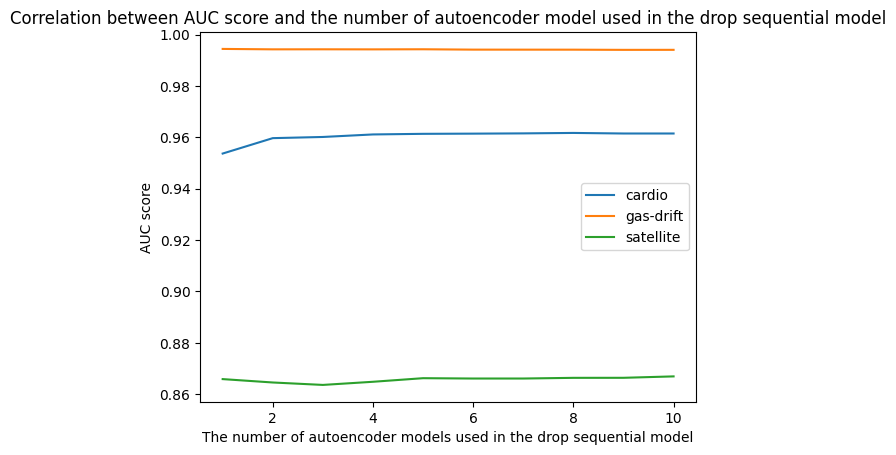

In [ ]:
# plot AUC score mean of each dataset according to the number of models in the sequential 
x = [i for i in range(1, 11)]
plt.plot(x, drop_cardio_mean, label='cardio')
plt.plot(x, drop_gas_drift_mean, label='gas-drift')
plt.plot(x, drop_satellite_mean, label='satellite')
plt.title('Correlation between AUC score and the number of autoencoder model used in the drop sequential model')
plt.xlabel('The number of autoencoder models used in the drop sequential model')
plt.ylabel('AUC score')
plt.legend(loc='best')
plt.show()

## 6. full_drop_synchronizing

All the prediction errors of the trained model are used as features in the data used to train the next model. In this case, we keep the shape of prediction errors instead of reshape them to get only one feature

In [ ]:
def inspect_full_drop_synchronizing(model_architecture, num_models, latent_list: list, data:list, legend:list, epochs, plot=True):
  """Create a syschronizing ensemble, in which the prediction errors of the last 
  trained model will be added as an feature to the original training data used for the next model.
  AUC score is calculated by using the error predictions of the last sychronized model
  
  Arguments:
    model_architecture -- the model architecture that we want to use to create model
    num_models -- the number of models which are integrated in one sychronizing ensemble model
    latent_list -- this contains the best size of latent space for each dataset in data respectively
    data -- a list of datasets
    legend -- name of datasets used to display on plot
    epochs -- 
  Returns:
    auc_dict -- this contains the auc score of each dataset in data
    plot
  """
  # Set random seed
  tf.keras.utils.set_random_seed(42)
  fullsyn_dict = {'dataset': legend, 'auc': []}

  for n in range(len(data)):
    df = data[n] # extract dataset n in data
    # extract X_train, X_test, y_test in df and scaled X_train, X_test
    X_train, X_test, y_test = extract_data(df)

    # list of pred_errors. Each element contains all the difference between inputs and their predictions of one model
    pred_errors_list = []
    test_errors_list = []
    errors_list = []
    X_plus_one = X_train.copy()
    X_test_one = X_test.copy()
    auc_list = []  # this list saves the AUC score of each model during training process


    for i in range(num_models):
      # 1. Create model
      # if pred_errors_list is not empty, then we have to concatenate the element at position i to the current training input
      if pred_errors_list:
        # convert the element at position i-1 in pred_errors_list to a 2D-tensor and then convert it to a numpy array. 
        pred_current = tf.reshape(pred_errors_list[i-1], [X_train.shape[0], -1]).numpy()
        # only the prediction errors of the last model is concatenated to the original training data before training the next one
        X_plus_one = np.concatenate((X_train.copy(), pred_current), axis=1)
        # convert the element at position i-1 in test_errors_list to a 2D-tensor and then convert it to a numpy array. 
        pred_test_current = tf.reshape(test_errors_list[i-1], [X_test.shape[0], -1]).numpy()
        # concatenate the pred_current to X_test also. This new X_test will be used for later predict method   
        X_test_one = np.concatenate((X_test.copy(), pred_test_current), axis=1)
      
      # training model
      autoencoder, history = training_model(model_architecture, X_plus_one, X_test_one, latent = latent_list[n], verbose = 0, loss = "mse", epochs=epochs, batch_size=128)
      
      # getting predictions of the training data
      preds = autoencoder.predict(X_plus_one)
      # calculate the difference between preds and the training data using (input - preds)**2
      pred_errors = tf.math.square(tf.math.subtract(preds, X_plus_one))
      # append pred_errors to the avg_pred_errors_list
      pred_errors_list.append(pred_errors)

      # getting predictions (recontructions) of the test data
      preds_test = autoencoder.predict(X_test_one)
      # calculate the difference between preds and the test data using (input - preds)**2. These values is used to create a new feature added to the next training loop
      pred_errors_test = tf.math.square(tf.math.subtract(preds_test, X_test_one))
      # append avg_preds_test to the test_errors_list
      test_errors_list.append(pred_errors_test)
      # calculate auc score
      errors_test = tf.keras.losses.mse(preds_test, X_test_one)
      errors_list.append(errors_test)

      # 4. Calculating AUC score of each training model 
      # calculate the average of pred_errors_test. We set axis = 1, so that the average is calculated by column-weise
      auc_score = roc_auc_score(y_test, errors_test)
      auc_list.append(auc_score)

    fullsyn_dict['auc'].append(auc_list)
  return fullsyn_dict

In [ ]:
fullsyn= inspect_full_drop_synchronizing(Autoencoder, 5, latent_list= [64, 112, 96], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'], epochs = 1500)

83/83 [==============================] - 0s 5ms/step


In [ ]:
fullsyn_dict = {'number of models': [1, 2, 3, 4, 5],
              'cardio': fullsyn['auc'][0],
              'gas_drift': fullsyn['auc'][1],
              'satellite': fullsyn['auc'][2]}

fullsyn_df = pd.DataFrame.from_dict(fullsyn_dict)
fullsyn_df

,number of models,cardio,gas_drift,satellite
0,1,0.953642,0.994281,0.869142
1,2,0.958678,0.994088,0.871094
2,3,0.949897,0.599713,0.847789
3,4,0.949638,0.608177,0.852062
4,5,0.956805,0.614379,0.836917


In [ ]:
fullsyn_dict = inspect_full_drop_synchronizing(Autoencoder, 10, latent_list= [64, 112, 96], data = [cardio, gas_drift, satellite], legend = ['cardio', 'gas-drift', 'satellite'], epochs = 1500)

47/47 [==============================] - 0s 3ms/step
pred_errors shape (1479, 21)
11/11 [==============================] - 0s 3ms/step
pred_current shape (1479, 21)
X_plus_one shape (1479, 42)
47/47 [==============================] - 0s 3ms/step
pred_errors shape (1479, 42)
11/11 [==============================] - 0s 3ms/step
pred_current shape (1479, 42)
X_plus_one shape (1479, 63)
47/47 [==============================] - 0s 3ms/step
pred_errors shape (1479, 63)
11/11 [==============================] - 0s 3ms/step
pred_current shape (1479, 63)
X_plus_one shape (1479, 84)
47/47 [==============================] - 0s 3ms/step
pred_errors shape (1479, 84)
11/11 [==============================] - 0s 3ms/step
pred_current shape (1479, 84)
X_plus_one shape (1479, 105)


KeyboardInterrupt: ignored

* When I try to train 10 models by using full_drop_synchronizing, it comes up with an error. The reason is that for each model, we add double features of the previous trained model. So it is a huge amount of features shoul be added to the next model. 
* I think one reason for the bad result of dataset `satellite`, when we use `full_drop_synchronizing_ensemble` is because the original training set has a big amount of features (128). So each time we try to double it. when a model is trained by using so many features of training data, the result is bad

## 7. Summarizing the results of trained models

* all datasets are trained with epochs=500
* latent space:
  * cardio: 4
  * gas-drift: 112
  * satellite: 64


In [ ]:
# create a dictionary contains all AUC scores of all datasets for each type of model was used to train
result_dict = {'Autoencoder': aut_dict['auc'],
               'Ensemble': ensemble_dict_2['auc'],
               'sequential synchronizing': sesyn_dict['auc'],
               'drop synchronizing': dropsyn_dict['auc'],
               'full drop synchronizing': fullsyn_dict['auc']}

results = pd.DataFrame.from_dict(result_dict, orient='index', columns=['cardio', 'gas-drift', 'satellite'])

In [ ]:
results

,cardio,gas-drift,satellite
Autoencoder,0.956063,0.984082,0.845696
Ensemble,0.945054,0.986991,0.838178
sequential synchronizing,0.952802,0.987060,0.871050
drop synchronizing,0.943827,0.970580,0.818531
full drop synchronizing,0.958968,0.625680,0.835216


In [ ]:
info

,dataset,shape,ndim,min,max
0,cardio,"(1479, 21)",2,-3.004892,14.025335
1,gas-drift,"(1796, 128)",2,-4839.446289,231364.171875
2,satellite,"(3080, 36)",2,31.000000,139.000000
